**Note: This section is still in a draft form.**

## Section 4: Procedural generation with arbitrarily many qubits

* Import standard things.

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from math import pi
from tools import plot_height

* We will use randomness at some point.

In [2]:
import random

* We will be using real quantum devices.
* They are currently not fault-tolerant, so there will be imperfections.
* While designing our method, we'll simulate this 'noise'.

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

* To mitigate for it, we'll be using some maths!

In [4]:
import scipy.linalg as la
import numpy as np

* This function creates a noise model, in which outputs on each qubit lie with the given probability `p`.

In [5]:
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        
    return noise_model

* We'll have the lies happen 1/10th of the time.

In [6]:
noise_model = get_noise(0.1)

* The folloqing function takes a given list of circuits and runs it on the given backend (simulator by default).
* The simulation uses a noise model if one is given.
* In addition to the circuits given in `circuits`, two additional circuits are run: one for which all outputs should be `0`, and one for which all should be `1`.
* The results from these are used to clean up the results from other circuits, using the same method as standard Qiskit measurement error mitigation.
* For each circuit in `circuits`, the probability that each qubit outputs a `1` is calculated (and cleaned up).
* These are compiled into a list `p` for each circuit, for which the probability `p[j]` refers to qubit `j`.
* The output `probs` contains these lists for each circuit, with `probs[k]` containing the `p` for the `k`th circuit.
* The output `raw_probs` contains the same lists of probabilities, but without the error mitigation. The results for the all `0` and all `1` circuits are also appended to this.

In [7]:
def get_probs(circuits,backend=Aer.get_backend('qasm_simulator'),noise_model=None):
    
    def get_raw_p(counts):

        n = len(list(counts.keys())[0])
        shots = sum(counts.values())

        p = [0]*n
        for bitstring in counts:
            for j in range(n):
                if bitstring[::-1][j]=='1':
                    p[j] += counts[bitstring]/shots

        return p

    n = circuits[0].n_qubits

    qc0 = QuantumCircuit(n,n)
    qc1 = QuantumCircuit(n,n)
    for j in range(n):
        qc0.measure(j,j)
        qc1.x(j)
        qc1.measure(j,j)

    benchmarks = [qc0,qc1]

    if noise_model:
        result = execute(circuits+benchmarks,backend,noise_model=noise_model,shots=8192).result()
    else:
        result = execute(circuits+benchmarks,backend,shots=8192).result()
        
    p0 = get_raw_p(result.get_counts(-2))
    p1 = get_raw_p(result.get_counts(-1))

    Minv = []
    for j in range(n):
        Minv.append( la.pinv( [[1-p0[j],1-p1[j]],[p0[j],p1[j]]] ) ) 

    raw_probs = []
    probs = []
    raw_probs = []
    for k in range(len(circuits)):
        mitigated_p = []
        raw_p = get_raw_p(result.get_counts(k))
        for j in range(n):
            p = np.dot( Minv[j], [1-raw_p[j],raw_p[j]] )[1]
            p = min(max(p,0),1)
            mitigated_p.append( p )
        probs.append( mitigated_p )
        raw_probs.append( raw_p  )
    raw_probs.append( get_raw_p(result.get_counts(-2))  )
    raw_probs.append( get_raw_p(result.get_counts(-1))  )
        
    return probs, raw_probs

* Let's see it in action.
* We will run circuits that should output all `0`s and all `1`s (`get_probs` will still run its own versions of these).

In [8]:
n = 4

qc0 = QuantumCircuit(n,n)
qc0.measure(qc0.qregs[0],qc0.cregs[0])

qc1 = QuantumCircuit(n,n)
qc1.x(qc1.qregs[0])
qc1.measure(qc1.qregs[0],qc1.cregs[0])

probs, raw_probs = get_probs([qc0,qc1],noise_model=noise_model)

/usr/local/lib/python3.7/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


* For the first circuit, the probability that the four qubits will output `1` should be zero.
* Let's see what we find from the raw results.

In [9]:
print(raw_probs[0])

[0.1014404296875, 0.0947265625, 0.099609375, 0.099365234375]


* Around 10% take the wrong value, due to the measurement errors.
* Now let's see what they are after clean up.

In [10]:
print(probs[0])

[0.0009215174320381936, 0, 0, 0.006853487663722069]


* Much closer to zero!
* Now let's look at results for the second circuit, where the output should be `1` with certainty.

In [11]:
print(raw_probs[1])

[0.9005126953125, 0.90185546875, 0.9002685546875, 0.9005126953125]


* The correct result again comes out only around 90% of the time.
* Again, let's look at the same after clean up.

In [12]:
print(probs[1])

[1, 1, 1, 1]


* This error mitigation again gives us a result that is much closer to the value we'd find without noise.

* We'll be using the 53 qubit *Rochester* device.
* Each qubit will be used to encode a pixel,  so we need a mapping between qubits and positions.
* The dictionary below defines the mapping we'll use.

In [13]:
rochester = {
    (2,1):5,(6,1):6,(2,5):28,(6,5):29,(2,7):51,(6,7):52,
    (0,3):16,(4,3):17,(8,3):18,(0,7):39,(4,7):40,(8,7):41}
for j in range(0,5):
    rochester[2+j,0] = j
for j in range(7,16):
    rochester[j-7,2] = j
for j in range(19,28):
    rochester[j-19,4] = j
for j in range(30,39):
    rochester[j-30,6] = j
for j in range(42,51):
    rochester[j-42,8] = j

* The probability for a `1` on each qubit will be used as the height for a height map.
* A 9x9 grid is used, so some positions have no qubit.
* To show this, here is a heightmap that has `height[x,y]=1` wherever there is a qubit, and has no entry otherwise (implying a height of zero).

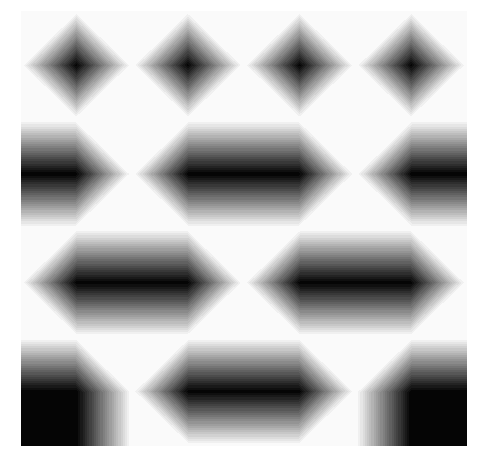

In [14]:
height = {}
for x in range(9):
    for y in range(9):
        if (x,y) in rochester:
            height[x,y] = 1
    
plot_height(height,color_map='gray')

* The following function takes a list of probabilities, `p`, from a device whose mapping between qubits and positions is specified by `device`.
* To fill in the gaps, each pixel without a value is set to the average of its valued neighbours.

In [15]:
def make_height(p,device):
    
    L = max(max(device.keys()))+1
    
    height = {}
    for pos in device:
        height[pos] = p[device[pos]]
    
    all_full = False
    while not all_full:
        all_full = True
        extra_height = {}
        for x in range(L):
            for y in range(L):
                if (x,y) not in height:
                    total = 0
                    num = 0
                    for (dx,dy) in [(0,1),(0,-1),(1,0),(-1,0)]:
                        if (x+dx,y+dy) in height:
                            total += height[x+dx,y+dy]
                            num += 1
                    if num==0:
                        all_full = False
                    else:
                        extra_height[x,y] = total/(num)
        for pos in extra_height:
            height[pos] = extra_height[pos]
                            
    return height

* We can now take results from a device and display them as a height map.
* The following function does the opposite: takes a height map and turns it into a quantum circuit.

In [16]:
def height2circuit_temp_1(height,device,limit=np.Inf):
    
    n = min( len(device), limit )
    
    qc = QuantumCircuit(n,n)
    
    for pos in height:
        if pos in device:
            j = device[pos]
            if j<limit:
                qc.ry(2*np.arcsin(np.sqrt(height[pos])),j)
                qc.measure(j,j)
        
    return qc

* We will test it all with the following height map.

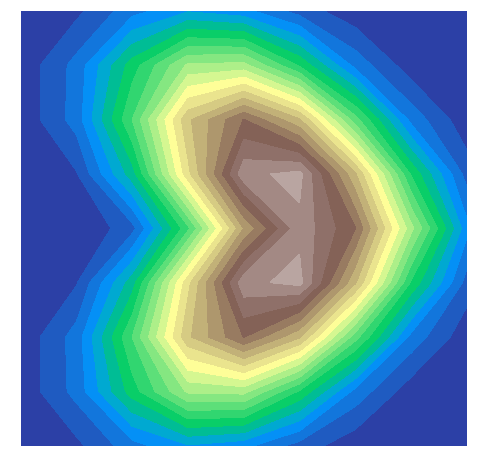

In [17]:
height_initial = {}
L = 9
for x in range(L):
    for y in range(L):
        height_initial[x,y] = (1 + np.cos( np.sqrt( (x-(L-1)/2)**2 + (y-(L-1)/2)**2 )/(L/5) ) )/2
        height_initial[x,y] = height_initial[x,y]*(1 + np.cos( ( abs(x+(L-1)/2) + abs(y-(L-1)/2) )/((L-1)/5) ) )/2
        
plot_height(height_initial)

* We'll first simulate it.
* Since 53 qubits is too many to simulate, we'll use a subset of 27.
* This is what the `limit` keyword is for in the above function.

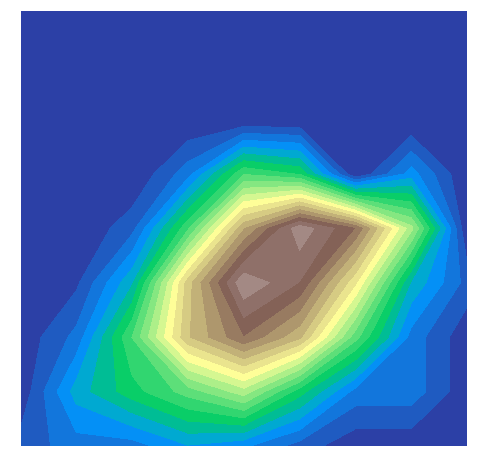

In [18]:
limit = 27
qc = height2circuit_temp_1(height_initial,rochester,limit=limit)

probs,raw_probs = get_probs([qc])
p = probs[0] + [0]*(53-limit)
height = make_height(p,rochester)
plot_height(height)

* Here we put half the image in (due to only using half the qubits), and got half the image out.
* Here are some results from running the circuit with no limit, using the 53 qubit *Rochester* device as the backend.

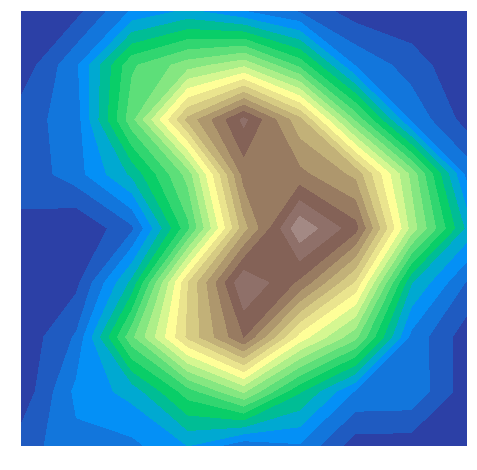

In [19]:
p=[0.10919456219850923, 0.16044568245125349, 0.09048625792811826, 0.11478420569329661, 0.01750400855157675, 0.17499999999999982, 0.11574979056129564, 0.007768721344880438, 0.08535402521823476, 0.3501374885426216, 0.5677950594693499, 0.7200184501845022, 0.5024050422955714, 0.3711212246586675, 0.10785066830542339, 0.01569726699369308, 0, 0.799728813559322, 0.07532605802502002, 0.03544720311097811, 0.0007676560900716691, 0.07124372050540444, 0.3079360506985453, 0.6212898497618173, 0.8309606258817493, 0.7347986312187418, 0.4237070807807376, 0.18767772511848335, 0.20848918523337134, 0.6287630189756027, 0.061037913417585465, 0.100013194352817, 0.34700485698866695, 0.6118154842190453, 0.7705248990578735, 0.6120502817511918, 0.3511696692659317, 0.1114186851211074, 0.022350530825107295, 0.010901728702694527, 0.43033920512447255, 0.005681818181818239, 0.0005247966413016135, 0.02600000000000008, 0.12480810561866737, 0.16719559044596638, 0.11907040328092963, 0.07396630934150084, 0.01814696485623008, 0.008415147265077194, 0, 0.31355697255336856, 0.11640714014432188]
height = make_height(p,rochester)
plot_height(height)

* The image does not come out perfectly, as we'd expect due to noise.
* It comes out pretty nicely, though!

* Now we'll define a new circuit to convert height maps to circuits
* This differs by adding in an implementation of every `cz` gate on the device, just before measurement.
* In theory, this will have no effect. In practice we can expect to see effects from noise.

In [20]:
def height2circuit_temp_2(height,device,limit=np.Inf):
    
    red = [(0, 1), (2, 3), (4, 6), (13, 12), (11, 10), (9, 5), (21, 22), (23, 24), (25, 29), (36, 35), (34, 33), (32, 28), (44, 45), (46, 47), (48, 52), (7, 16), (30, 39), (18, 27), (41, 50)]
    green = [(7, 8), (9, 10), (11, 17), (22, 23), (21, 20), (16, 19), (30, 31), (32, 33), (34, 40), (45, 46), (43, 44), (39, 42), (15, 14), (13, 6), (25, 26), (38, 37), (36, 29), (48, 49), (2, 1)]
    blue = [(0, 5), (9, 8), (19, 20), (21, 28), (32, 31), (42, 43), (44, 51), (11, 12), (13, 14), (15, 18), (27, 26), (25, 24), (23, 17), (34, 35), (36, 37), (38, 41), (50, 49), (48, 47), (46, 40), (4, 3)]
    
    n = min( len(device), limit )
    
    qc = QuantumCircuit(n,n)
    
    for pos in height:
        if pos in device:
            j = device[pos]
            if j<limit:
                qc.ry(2*np.arcsin(np.sqrt(height[pos])),j)
    
    for pairs in [red,green,blue]:
        for pair in pairs:
            if pair[0]<limit and pair[1]<limit:
                qc.cz(pair[0],pair[1])
    
    for pos in height:
        if pos in device:
            j = device[pos]
            if j<limit:
                qc.measure(j,j)
        
    return qc

* The results from a simulated run come out as before.

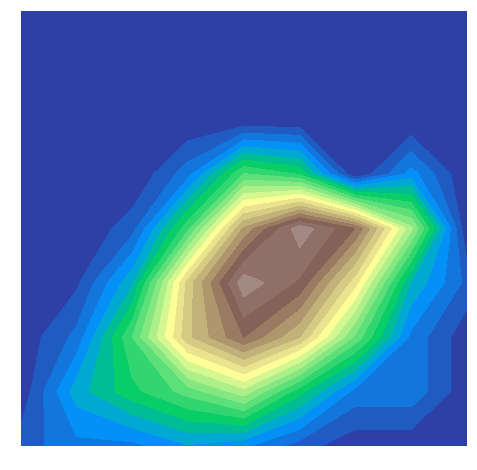

In [21]:
qc = height2circuit_temp_2(height_initial,rochester,limit=limit)

probs,raw_probs = get_probs([qc])
p = probs[0] + [0]*(53-limit)
height = make_height(p,rochester)
plot_height(height)

* Results from a real run are noisier than before, as expected.
* Still pretty good, though!

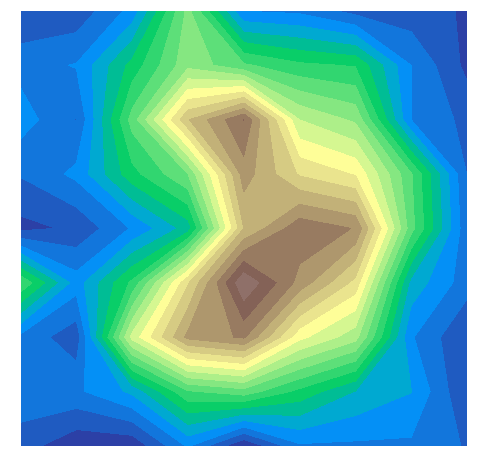

In [22]:
p = [0.009271721250186687, 0.12571347031963487, 0, 0.11378687537627952, 0.11220366379310348, 0.16896345116836464, 0.19807037457434734, 0.1080806799441838, 0.0542184607246759, 0.4533512464546947, 0.6510054501033639, 0.6864168271367205, 0.49212417800886976, 0.41575859178541497, 0.12443894134034998, 0.039715719063544874, 0.31570404436629257, 0.7955108785458552, 0.09762639131017838, 0.026998961578400885, 0.0476251114223862, 0.12394067796610185, 0.21739753511034693, 0.5995431382885258, 0.7080310551100926, 0.6775725593667545, 0.33528404224950037, 0.08964501881236696, 0.26531620553359686, 0.5159870250231695, 0.13996763754045305, 0.0779101741521539, 0.3371308016877635, 0.5970209884901827, 0.7207501019160213, 0.4394103620203772, 0.39190687361419063, 0.1193887297039159, 0.06800556770729752, 0.10569610429923938, 0.3264977296030467, 0.028944911297852392, 0.04038814581694213, 0.052019278710320804, 0.13344441078461078, 0.3722366710013004, 0.11908528692650666, 0.11099187490418526, 0.06481123566550703, 0.05513666352497655, 0.03586081142683477, 0.2545377796538624, 0.27651361235270205]
height = make_height(p,rochester)
plot_height(height)

* The final version of `height2circuit` will have some random single qubit rotations after the `cz` gates.
* These will have the effect of perturbing the image using quantum intereference effects.

In [23]:
def height2circuit(height,device,limit=np.Inf,theta=np.pi/2):
    
    red = [(0, 1), (2, 3), (4, 6), (13, 12), (11, 10), (9, 5), (21, 22), (23, 24), (25, 29), (36, 35), (34, 33), (32, 28), (44, 45), (46, 47), (48, 52), (7, 16), (30, 39), (18, 27), (41, 50)]
    green = [(7, 8), (9, 10), (11, 17), (22, 23), (21, 20), (16, 19), (30, 31), (32, 33), (34, 40), (45, 46), (43, 44), (39, 42), (15, 14), (13, 6), (25, 26), (38, 37), (36, 29), (48, 49), (2, 1)]
    blue = [(0, 5), (9, 8), (19, 20), (21, 28), (32, 31), (42, 43), (44, 51), (11, 12), (13, 14), (15, 18), (27, 26), (25, 24), (23, 17), (34, 35), (36, 37), (38, 41), (50, 49), (48, 47), (46, 40), (4, 3)]
    
    n = min( len(device), limit )
    
    qc = QuantumCircuit(n,n)
    
    for pos in height:
        if pos in device:
            j = device[pos]
            if j<limit:
                qc.ry(2*np.arcsin(np.sqrt(height[pos])),j)
    
    for pairs in [red,green,blue]:
        for pair in pairs:
            if pair[0]<limit and pair[1]<limit:
                qc.cz(pair[0],pair[1])
    
    for pos in height:
        if pos in device:
            j = device[pos]
            if j<limit:
                rand_theta = theta*2*(random.random()-0.5)
                if random.random()<0.5:
                    qc.rx(rand_theta,j)
                else:
                    qc.ry(rand_theta,j)
                qc.measure(j,j)
        
    return qc

* Here are three examples from a simulation.
* Remember, there is no noise here.
* The effects are induced on purpose by `height2circuit`.

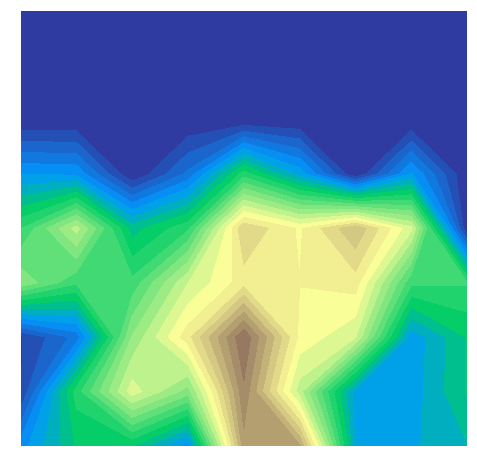

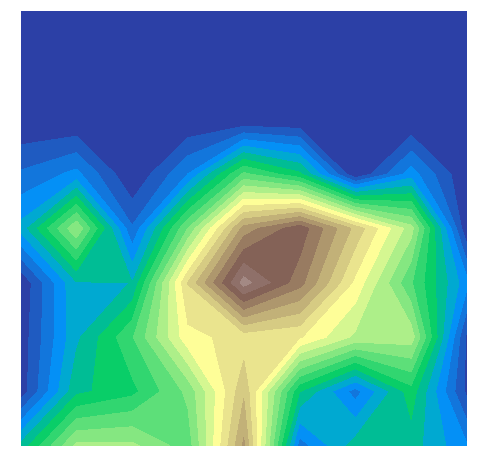

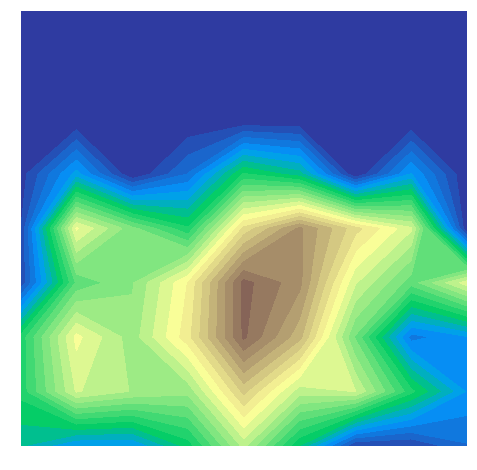

In [24]:
for j in range(3):
    qc = height2circuit(height_initial,rochester,limit=limit)

    probs,raw_probs = get_probs([qc])
    p = probs[0] + [0]*(53-limit)
    height = make_height(p,rochester)
    plot_height(height)

* Below are 70 samples of real runs.
* A random selection of 3 are shown.

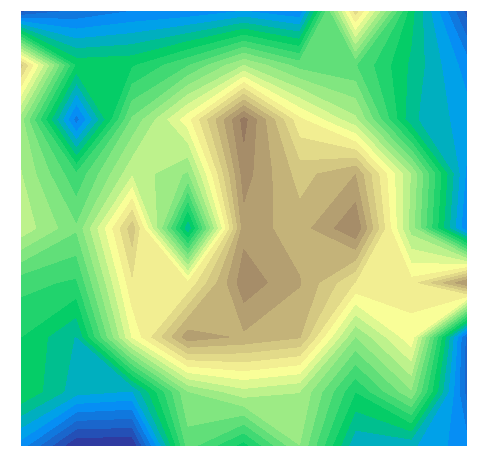

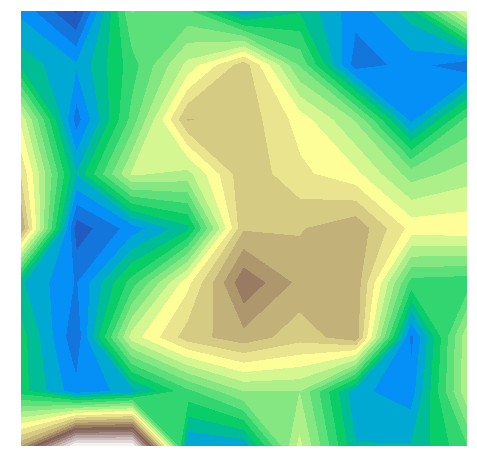

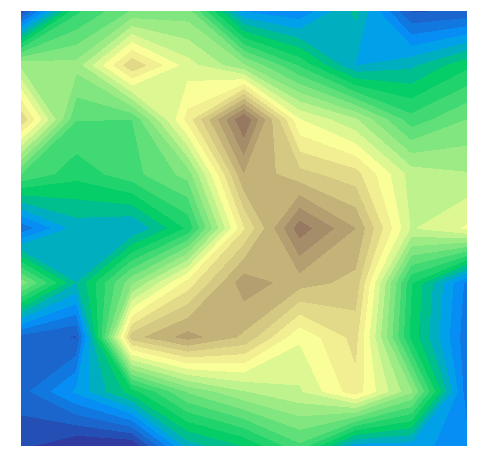

In [25]:
probs = [[0, 0.19980438731311997, 0.1119966442953022, 0.21462029808374739, 0.21212121212121224, 0.24343083787803665, 0.2839741708247726, 0.25150698986789777, 0.20750605326876514, 0.4778840406455469, 0.6301094890510947, 0.5461853259280911, 0.5143323926927077, 0.5697781885397412, 0.5143587430461585, 0.10184799221898017, 0.5930624915643137, 0.7625086147484492, 0.1973737103041672, 0.045274725274725036, 0.1667731629392972, 0.3367891446866902, 0.33649683649683637, 0.640562597673207, 0.5971293199554069, 0.5477222003413416, 0.369032258064516, 0.16890783863561826, 0.3180645161290323, 0.5593991807009557, 0.6222222222222223, 0.40617608409986855, 0.39308893176635673, 0.5183673469387756, 0.7164975974372665, 0.5398078975453575, 0.4958256686005375, 0.27778591301801153, 0.4005019720329868, 0.3007471980074722, 0.46801444043321316, 0.2579929531515073, 0.20536663124335813, 0.0476190476190477, 0.24824026278742387, 0.42695278969957084, 0.3217508417508419, 0.13518770667185356, 0.07979341510652026, 0.28387703889585947, 0.09453940402359687, 0.7278629644978588, 0.20491273432449914], [0, 0.277350845326254, 0.04865771812080566, 0.20880056777856643, 0.4573863636363638, 0.18393653941497268, 0.30217199882594664, 0.14479928177504156, 0.06464891041162235, 0.5650029886431559, 0.5669708029197078, 0.6052323881905874, 0.5893361057478095, 0.5055452865064696, 0.3486693730266125, 0.16729192719188551, 0.23053043595626926, 0.677050310130944, 0.1362722765643843, 0.2128937728937726, 0.4724600638977636, 0.3322152767190122, 0.23643023643023633, 0.6318805348150719, 0.6815774804905239, 0.7081528160693185, 0.5767741935483869, 0.16693998032141688, 0.255, 0.5336822940373235, 0.2423025435073629, 0.12391590013140605, 0.3425714786879494, 0.5925170068027211, 0.7261078483715964, 0.49754535752401285, 0.4598839677373707, 0.2057402255088594, 0.4523126568662604, 0.19863013698630153, 0.47754512635379076, 0.23789638522771764, 0.22143995749202977, 0.2716894977168951, 0.16048803378695464, 0.23931330472103013, 0.32026936026936037, 0.22641509433962248, 0.31530019367333756, 0.18506900878293603, 0.06489184692179682, 0.511120320486255, 0.48243912949795315], [0.8556851311953357, 0.2410227749056867, 0.4072986577181211, 0.2824698367636622, 0.21076839826839838, 0.28507684680218126, 0.31127091282653363, 0.1923816852635628, 0.499273607748184, 0.4620442319187089, 0.6264598540145982, 0.5575855013154047, 0.5737412743205111, 0.45425138632162665, 0.10434521124642905, 0.3362512157843545, 0.20394115265217966, 0.7546519641626463, 0.15771137612220285, 0.5369963369963366, 0.15527156549520774, 0.33145296539106583, 0.3876123876123875, 0.578225386351797, 0.6896599777034559, 0.6979125640015753, 0.4755555555555554, 0.14758937356510332, 0.2880645161290323, 0.5625853436504323, 0.24497991967871496, 0.4102496714848883, 0.33695842834590417, 0.5961904761904762, 0.7147624132407902, 0.4529348986125934, 0.4808263761143341, 0.20676526577829854, 0.21871638580136255, 0.06870070568700726, 0.3757400722021662, 0.23711340206185566, 0.42893198724760895, 0.07893020221787356, 0.12185202565305818, 0.3378540772532189, 0.1991919191919193, 0.3244504960124488, 0.2871530019367333, 0.11841279799247183, 0.3128119800332777, 0.1418704240917254, 0.32105149752208584], [4.440892098500626e-16, 0.3636998742489869, 0.351090604026846, 0.1792760823278922, 0.493641774891775, 0.18691125433812583, 0.4223657176401526, 0.4110555341798126, 0.14140435835351095, 0.47803347280334724, 0.6403284671532845, 0.5704472376498099, 0.5025991385712165, 0.34334565619223656, 0.5296947827394377, 0.11532583020703074, 0.24686192468619236, 0.657339765678842, 0.43507972665148054, 0.1047619047619045, 0.3375079872204473, 0.15230980332367752, 0.27322677322677313, 0.6256294495572147, 0.5816610925306578, 0.678613627412367, 0.5161290322580644, 0.2622171203673336, 0.5885483870967743, 0.49135184342284927, 0.18045515394912987, 0.09093298291721422, 0.38765128924750036, 0.5053061224489797, 0.6599038974906567, 0.5705442902881537, 0.45875194566294025, 0.16327427148923718, 0.0855145213338114, 0.17766708177667098, 0.6551624548736464, 0.2397233459480621, 0.5162061636556855, 0.4359099804305285, 0.45096198967620843, 0.15982832618025758, 0.39326599326599343, 0.12799066329507863, 0.05526145900581012, 0.38299874529485567, 0.12600211768264996, 0.2467191601049869, 0.24218918336565404], [0.6064139941690962, 0.27134274137208325, 0.6346476510067116, 0.24215755855216473, 0.18709415584415598, 0.23847297967278136, 0.2917522747285002, 0.384891624983968, 0.4440677966101695, 0.46383741781231325, 0.5952554744525544, 0.6835720549546914, 0.4871528293479877, 0.5743992606284658, 0.10374379792512398, 0.05738502153675148, 0.14900796328789295, 0.7258442453480357, 0.4163205145383893, 0.23882783882783853, 0.07884984025559111, 0.11007775575545067, 0.23576423576423566, 0.564855009550269, 0.6846432552954291, 0.6218983851910199, 0.36702508960573466, 0.42046572646769437, 0.3340322580645162, 0.5671370050068274, 0.3887550200803214, 0.1258869908015769, 0.388528328363445, 0.5050340136054422, 0.5004004271222637, 0.4601921024546425, 0.4485637469930662, 0.36989310294333005, 0.32287558264610977, 0.14508094645080966, 0.6112635379061373, 0.3111053112358085, 0.05884697130712008, 0.2685909980430529, 0.28765837634913194, 0.5833476394849786, 0.3163636363636365, 0.12799066329507863, 0.15455132343447378, 0.030112923462986274, 0.069127212222054, 0.1678408619975135, 0.2835595776772249], [0.1530612244897962, 0.41972893670532335, 0.47651006711409416, 0.2552164655784245, 0.2532467532467534, 0.13534952900347041, 0.2902847079542119, 0.27241246633320493, 0.08401937046004848, 0.45322773460848775, 0.6403284671532845, 0.6805027769657993, 0.589484627951879, 0.42467652495378916, 0.13682153059690266, 0.10115325830207035, 0.4347415305709272, 0.7608545830461749, 0.5397293313680824, 0.06402930402930378, 0.0966134185303515, 0.2139045586217413, 0.2385947385947385, 0.6023615210974126, 0.5027870680044594, 0.53039254299593, 0.4123297491039425, 0.4055428009183339, 0.28548387096774197, 0.5209376422394173, 0.2136546184738956, 0.08843626806833117, 0.3708121382213646, 0.49006802721088444, 0.7167645488521089, 0.5028815368196371, 0.4887505306353472, 0.15038805095914493, 0.14359985657941915, 0.21004566210045678, 0.3179783393501806, 0.5583974944538693, 0.20164718384697133, 0.15296803652968047, 0.18254340685124368, 0.17613733905579404, 0.16309764309764324, 0.11009531219607063, 0.1793415106520335, 0.0701066499372648, 0.057026168507033556, 0.24768614449509604, 0.13962508080155145], [0, 0.13497275394718453, 0.45595637583892656, 0.19020581973030526, 0.2272727272727274, 0.12791274169558742, 0.7737012034047549, 0.30652815185327675, 0.2721549636803875, 0.46099820681410636, 0.6142335766423356, 0.6321251096170709, 0.5945343828902423, 0.3914048059149723, 0.21455420237558256, 0.2364874253161039, 0.26143879066000797, 0.744314266023432, 0.3816159721291705, 0.5054945054945051, 0.29878594249201285, 0.11251715200487893, 0.5389610389610389, 0.5153672512588989, 0.7242196209587515, 0.68898516476303, 0.6541935483870966, 0.12676287307313874, 0.33532258064516135, 0.5801092398725535, 0.37858099062918343, 0.34086727989487514, 0.543939659708823, 0.5959183673469388, 0.7148958889482114, 0.47385272145144075, 0.4526673270128766, 0.17835700688241335, 0.11168877733954824, 0.16438356164383577, 0.44851985559566804, 0.07112097089912563, 0.03892136025504781, 0.06392694063926951, 0.11465665571719082, 0.3205150214592275, 0.23313131313131327, 0.3421513324255979, 0.32472562943834726, 0.4457340025094102, 0.26062622901225213, 0.2652300041442189, 0.18142641672053444], [0, 0.14517255833449763, 0.4278523489932887, 0.3528743789921931, 0.15692640692640705, 0.18790282597917685, 0.31288523627825066, 0.106322944722329, 0.30435835351089585, 0.40570830842797373, 0.609671532846715, 0.5200233849751533, 0.5731471855042329, 0.5508317929759704, 0.21380243572395125, 0.04293455606502715, 0.2630584424348764, 0.6354238456237076, 0.5433471794184642, 0.4189010989010986, 0.0682428115015975, 0.09498399146211327, 0.3722943722943722, 0.5554783816634831, 0.717530657748049, 0.6303006432978862, 0.3569892473118278, 0.37602492620531325, 0.33725806451612905, 0.560992262175694, 0.4077643908969212, 0.5268068331143232, 0.3330994562357481, 0.5238095238095238, 0.547650827549386, 0.5560298826040555, 0.4825244092259797, 0.13076585151559536, 0.11133022588741484, 0.2941054379410545, 0.556678700361011, 0.044760537648440527, 0.10959086078639745, 0.14416177429876068, 0.21445330830595977, 0.1867811158798284, 0.1917845117845119, 0.23944757829216087, 0.08276307295029044, 0.4982747804265997, 0.06277416427166826, 0.513606851775107, 0.06593406593406598], [0, 0.26854827441665496, 0.19085570469798685, 0.30631653655074526, 0.2683982683982685, 0.15964303420922155, 0.2813325506310538, 0.25112222649737065, 0.14697336561743346, 0.5053795576808129, 0.5999999999999998, 0.5494007600116924, 0.5755235407693452, 0.4131238447319777, 0.26251691474966166, 0.04182298179797144, 0.46416520448103654, 0.7700895933838731, 0.2890258609138415, 0.23560439560439533, 0.12971246006389783, 0.3701783808507396, 0.547119547119547, 0.5742316374370549, 0.5250836120401339, 0.49533937245634746, 0.5310394265232974, 0.19448999672023617, 0.478225806451613, 0.516613563950842, 0.22489959839357437, 0.44993429697766096, 0.3881775127170672, 0.5891156462585034, 0.661639081687133, 0.480042689434365, 0.42790434413471046, 0.48894420852247783, 0.5876658300466118, 0.17579908675799102, 0.33270758122743693, 0.07516638392274562, 0.2790913921360255, 0.25799086757990874, 0.415610824339121, 0.20875536480686704, 0.20040404040404053, 0.4746158334954287, 0.09115558424790181, 0.5537954830614805, 0.4990167901981544, 0.49882580466915327, 0.19521654815772468], [0, 0.1524381724186111, 0.3863255033557049, 0.23165365507452101, 0.37662337662337675, 0.2622706990580068, 0.23569122395068978, 0.3506476850070539, 0.04479418886198555, 0.45591751344889414, 0.6275547445255473, 0.6397252265419467, 0.5747809297489976, 0.41358595194085024, 0.5617200420989324, 0.18479922189801307, 0.1865298960723443, 0.7627842866988283, 0.2645048907945866, 0.06710622710622685, 0.3704792332268371, 0.38938862631498716, 0.3573093573093572, 0.5546101753776695, 0.7148829431438127, 0.47512143888670066, 0.5172759856630823, 0.12479501475893738, 0.2319354838709678, 0.5725989986345015, 0.18447121820615803, 0.13626806833114327, 0.4607963515172776, 0.6042176870748299, 0.7187666844634276, 0.45976520811099253, 0.46398754775718115, 0.17879630985503014, 0.1669057009680889, 0.14009962640099644, 0.5789169675090254, 0.04306407412240633, 0.1582093517534538, 0.053163731245923135, 0.3923040825903333, 0.17321888412017175, 0.42154882154882173, 0.11690332620112803, 0.20387346675274365, 0.11480552070263492, 0.16457419452427757, 0.3177234424644288, 0.13466925231631122], [0.17930029154518978, 0.333938801173676, 0.11912751677852373, 0.47977288857345635, 0.31250000000000017, 0.15071888943976197, 0.2995303786322278, 0.1435167372066178, 0.23510895883777244, 0.4426180514046622, 0.6009124087591239, 0.5358082432037414, 0.5113619486113176, 0.44408502772643244, 0.1547135769057284, 0.07016812560789222, 0.15751113510595208, 0.6413507925568571, 0.17258475144043947, 0.46593406593406567, 0.1394249201277956, 0.11434669919195013, 0.25957375957375944, 0.495572147942351, 0.6896599777034559, 0.6079821452015227, 0.3551254480286737, 0.45621515250901934, 0.3345161290322581, 0.5386891215293581, 0.2768406961178047, 0.12049934296977664, 0.3697596912822312, 0.6093877551020409, 0.714095034703684, 0.5338313767342582, 0.3810669308051506, 0.18362864255381472, 0.4619935460738617, 0.0975508509755087, 0.36375451263537917, 0.26177737178650656, 0.3569341126461212, 0.27756033920417494, 0.44720788362271235, 0.3715021459227468, 0.15016835016835028, 0.22446994748103463, 0.4417043253712072, 0.286543287327478, 0.3285433368628043, 0.5276971957452687, 0.3376427494074554], [0, 0.1147128685203297, 0.08976510067114118, 0.3215046132008517, 0.41071428571428586, 0.18839861179970252, 0.6982682712063399, 0.16557650378350638, 0.15569007263922519, 0.4503885236102809, 0.6430656934306568, 0.6280327389652147, 0.5569582652606566, 0.566543438077634, 0.2936400541271989, 0.05780186188689737, 0.6162775003374275, 0.7376981392143348, 0.5397293313680824, 0.05743589743589719, 0.15565495207667737, 0.15901814300960526, 0.2117882117882117, 0.5181455113735022, 0.5, 0.5796245240908492, 0.3337634408602149, 0.14102984585109873, 0.23080645161290325, 0.533227127901684, 0.28995983935742975, 0.35256241787122206, 0.3823890545518329, 0.5085714285714287, 0.6995461825947678, 0.4806830309498399, 0.48620348096787874, 0.2217015668472691, 0.5308354248834708, 0.30904939809049414, 0.5163898916967511, 0.4637870285788856, 0.19713071200850157, 0.049575994781474314, 0.24620678867511353, 0.21957081545064383, 0.16417508417508428, 0.10309278350515452, 0.3337637185280826, 0.24262860727728985, 0.11889275450007546, 0.21232214394253351, 0.4458090928679166], [0, 0.4743607656839457, 0.32340604026845654, 0.2922640170333571, 0.19805194805194817, 0.21219633118492798, 0.22659230995010277, 0.11170963190970876, 0.18886198547215505, 0.48535564853556484, 0.595802919708029, 0.6432329728149663, 0.5256200802019904, 0.39001848428835484, 0.28702450759284315, 0.04613033208281234, 0.15332703468754202, 0.7541006202618882, 0.19764169904863993, 0.08029304029304006, 0.0664536741214058, 0.3302332672663517, 0.25258075258075247, 0.568327834693523, 0.6152452619843924, 0.5314428252592883, 0.4904659498207884, 0.14808133814365365, 0.31725806451612903, 0.533227127901684, 0.15555555555555567, 0.07910643889618926, 0.3115242939835116, 0.520952380952381, 0.5772824345969034, 0.49711846318036285, 0.37625583698882115, 0.12095475179382056, 0.09949802796701326, 0.11436280614362826, 0.38685920577617344, 0.5125929792509462, 0.344845908607864, 0.43085453359425974, 0.13686844986704222, 0.2626609442060086, 0.15811447811447824, 0.17000583544057563, 0.0622336991607488, 0.47992471769134243, 0.1343215852367265, 0.31979555187180553, 0.5483731954320191], [0, 0.1525778957663825, 0.14093959731543648, 0.21490418736692699, 0.29843073593073605, 0.09419930589985115, 0.34267684179630176, 0.2910093625753494, 0.08813559322033904, 0.5590257023311417, 0.5726277372262771, 0.5701549254603916, 0.5481954552205556, 0.45748613678373384, 0.3192001202826642, 0.05655134083645969, 0.10203806181670924, 0.7819434872501722, 0.25686721157711373, 0.5271794871794868, 0.39769968051118215, 0.5016008537886875, 0.37712287712287695, 0.5775308213231463, 0.7024804905239688, 0.48824996717867913, 0.5012186379928314, 0.1836667759921286, 0.4714516129032259, 0.5723714155666818, 0.46131191432396257, 0.16031537450722735, 0.394492194351868, 0.5436734693877551, 0.6615056059797118, 0.5097118463180363, 0.42450827791141915, 0.26167813735539625, 0.09806382215847975, 0.2602739726027399, 0.36375451263537917, 0.0609421897429205, 0.056987247608926664, 0.2757664709719505, 0.42577819490067265, 0.4156223175965666, 0.17292929292929304, 0.1056214744213187, 0.07514525500322781, 0.11590338770388965, 0.056874905460595815, 0.5701063682829121, 0.2165481577246284], [1, 0.5791532765125051, 0.12038590604026878, 0.21064584811923354, 0.4373647186147188, 0.19286068418443236, 0.33592603463457593, 0.18224958317301515, 0.38789346246973366, 0.47325164375373585, 0.591788321167883, 0.6644256065477929, 0.48388534085845847, 0.411275415896488, 0.20478123590437525, 0.06183131860497435, 0.1936833580780131, 0.7405926946933148, 0.6585823395417391, 0.16483516483516455, 0.24306709265175724, 0.2847995121207503, 0.5136530136530135, 0.5822191352665392, 0.5259197324414716, 0.6598398319548376, 0.42150537634408586, 0.1495572318793047, 0.433225806451613, 0.528675466545289, 0.5394912985274433, 0.28383705650459923, 0.32660936677775826, 0.5937414965986395, 0.6050453817405232, 0.4890074706510139, 0.3799349087307201, 0.26328891492165774, 0.127465041233417, 0.4113740141137403, 0.34353790613718427, 0.48231763017095136, 0.18650371944739638, 0.3760600130463145, 0.18801814484592536, 0.15931330472103014, 0.13521885521885535, 0.2943007197043375, 0.24790187217559712, 0.6135508155583438, 0.1028588715776734, 0.5774278215223098, 0.13208360267183805], [0, 0.1624982534581528, 0.13045302013422844, 0.4481192334989354, 0.21266233766233777, 0.3326722855726325, 0.18373936014088643, 0.34179812748492994, 0.10435835351089595, 0.5603705917513448, 0.6091240875912407, 0.6007015492546038, 0.5667607307292443, 0.40665434380776333, 0.4175311983160427, 0.22439905516187297, 0.3950600620866513, 0.6452101998621638, 0.31274286479967833, 0.35267399267399235, 0.5054313099041534, 0.3864918432687911, 0.5104895104895104, 0.5608612606355269, 0.48494983277591974, 0.5475909150584217, 0.46336917562723995, 0.16546408658576583, 0.4387096774193549, 0.6046882111970868, 0.1900937081659974, 0.20433639947437582, 0.3513418698473951, 0.6163265306122448, 0.5774159103043247, 0.4685165421558164, 0.380783925286543, 0.29199004246595417, 0.10218716385801363, 0.07368202573682048, 0.30758122743682326, 0.36199921701683413, 0.18079171094580235, 0.03114807566862371, 0.13483497575473186, 0.21356223175965672, 0.1571717171717173, 0.1065940478506126, 0.0887023886378308, 0.04171894604767887, 0.14566631371955813, 0.45199613206243955, 0.20986856280973937], [0.6530612244897962, 0.2717619114153974, 0.5553691275167787, 0.4721078779276082, 0.18492965367965378, 0.12592959841348528, 0.3768711476372175, 0.4912145697062971, 0.20266343825665867, 0.47519426180514046, 0.6235401459854013, 0.5673779596609178, 0.47289469775731485, 0.6016635859519408, 0.10058637798827237, 0.18299291371404752, 0.1006883520043189, 0.7404548587181253, 0.6588503282862118, 0.10197802197802172, 0.12511182108626206, 0.301265436804391, 0.5860805860805859, 0.6086126063552699, 0.6387959866220736, 0.6098201391623997, 0.47340501792114686, 0.29763857002295835, 0.24258064516129033, 0.6397360036413291, 0.24524765729585019, 0.09658344283837059, 0.5406069110682336, 0.6175510204081632, 0.6869994660971703, 0.44204909284951976, 0.5029008065657279, 0.14365207204568758, 0.3409824309788455, 0.18596928185969297, 0.43205776173285215, 0.4037583191961373, 0.04729011689691816, 0.05919765166340518, 0.42186766776161433, 0.19605150214592282, 0.24175084175084186, 0.21065940478506112, 0.38050355067785663, 0.05175658720200761, 0.08682498865527136, 0.24892941013952205, 0.24994613229907356], [0.7565597667638486, 0.47142657538074606, 0.12416107382550357, 0.4848828956706885, 0.5635822510822514, 0.18145761031234509, 0.37290871734663933, 0.09760164165704749, 0.07699757869249402, 0.4303646144650328, 0.5821167883211676, 0.6718795673779596, 0.5639388088519236, 0.5480591497227357, 0.1989174560216508, 0.2776156731971654, 0.26953704953435, 0.7609924190213644, 0.1866541605252579, 0.4634432234432231, 0.3638338658146965, 0.12654368043909148, 0.4077589077589076, 0.6174683104705677, 0.5557413600891862, 0.6631219640278323, 0.4272401433691755, 0.32961626762873075, 0.23580645161290326, 0.5279927173418297, 0.24846050870147263, 0.38396846254927725, 0.4902648658130152, 0.5077551020408164, 0.5417778964228511, 0.4783351120597652, 0.4515353049384461, 0.4518963244984626, 0.35030476873431343, 0.18845994188459958, 0.3976895306859208, 0.4831006133368133, 0.3852284803400638, 0.29435746901500337, 0.2299389957766308, 0.5143347639484979, 0.20430976430976444, 0.2680412371134019, 0.21691413815364746, 0.08249686323713931, 0.15670851610951425, 0.2613620665837823, 0.3292393880629175], [0.8323615160349855, 0.5707698756462203, 0.15058724832214787, 0.22625975869410936, 0.32345779220779236, 0.3440753594447197, 0.7326093337246845, 0.35898422470180824, 0.12857142857142861, 0.5116557083084279, 0.6375912408759121, 0.6549254603916982, 0.5202732808554881, 0.39325323475046203, 0.10524733122838664, 0.3211060163957204, 0.40315832096099335, 0.6971743625086146, 0.11094734021171111, 0.03531135531135507, 0.3373801916932908, 0.1797530111297455, 0.44721944721944706, 0.5820454940093764, 0.609113712374582, 0.6748063542076932, 0.4789964157706092, 0.3348638897999344, 0.38725806451612904, 0.4640418752844787, 0.29585006693440435, 0.5052562417871221, 0.3787054902648657, 0.47319727891156466, 0.7206353443673252, 0.5259338313767343, 0.3891325880854676, 0.27558939815492767, 0.5132664037289353, 0.14508094645080966, 0.5777617328519857, 0.2583844447344382, 0.08634431455897981, 0.08529028049576001, 0.19302361958392, 0.24309012875536484, 0.43340067340067356, 0.4600272320560201, 0.4816010329244674, 0.1035131744040151, 0.1417334745121765, 0.7465119491642492, 0.1797026502908857], [1, 0.1036747240463881, 0.11703020134228215, 0.39787083037615334, 0.3494318181818183, 0.2503718393653941, 0.5622248312298209, 0.08785430293702697, 0.4094430992736078, 0.4294680215182307, 0.6481751824817517, 0.5415083308973982, 0.6027031041140652, 0.40064695009242135, 0.3202525935949481, 0.040850354314297684, 0.2584694290727492, 0.7579600275671948, 0.22028674795658576, 0.10754578754578728, 0.3805750798722045, 0.3247446257051381, 0.4786879786879785, 0.48324361868379906, 0.5844481605351172, 0.6967309964552972, 0.4063082437275984, 0.12823876680878976, 0.2887096774193548, 0.6015020482476103, 0.29451137884872836, 0.40039421813403414, 0.492545167514471, 0.5989115646258504, 0.6181260010678057, 0.4546424759871931, 0.5004952596575633, 0.19944354956801885, 0.32108282538544286, 0.2268576172685763, 0.47061371841155253, 0.3105833224585671, 0.3421891604675877, 0.18166992824527078, 0.4470514625371501, 0.21390557939914173, 0.17144781144781157, 0.13188095701225427, 0.11323434473854092, 0.11590338770388965, 0.15232188776281935, 0.31385550490399233, 0.23981900452488697], [0, 0.2399049881235154, 0.40645973154362436, 0.2661462029808375, 0.2964015151515153, 0.3227565691621219, 0.30481361901966547, 0.35936898807233536, 0.3498789346246974, 0.39210998206814107, 0.5852189781021895, 0.650833089739842, 0.501262438734591, 0.4131238447319777, 0.12058337092166585, 0.03848825899680429, 0.10716695910379254, 0.5152308752584422, 0.5633123408816828, 0.40029304029303997, 0.1252396166134186, 0.44366519286476613, 0.4771894771894771, 0.5987150546969959, 0.6681995540691194, 0.672968360246816, 0.4058781362007167, 0.2822236798950476, 0.21661290322580645, 0.5411925352753755, 0.16224899598393583, 0.08055190538764787, 0.3851955797228556, 0.6004081632653061, 0.5908969567538708, 0.560298826040555, 0.4465827083628129, 0.38585444428173976, 0.3031552527787738, 0.01971772519717746, 0.46064981949458506, 0.486624037583192, 0.06801275239107332, 0.30528375733855195, 0.2604411074612859, 0.2980257510729615, 0.20525252525252538, 0.2139661544446604, 0.4333118140735958, 0.0622647427854455, 0.37452730297988185, 0.4086199751346871, 0.08101702219349283], [0, 0.5168366634064551, 0.1140939597315439, 0.1779985805535842, 0.3126352813852815, 0.14576103123450668, 0.3046668623422366, 0.560215467487495, 0.08910411622276038, 0.4778840406455469, 0.5786496350364961, 0.6612101724641917, 0.4641318877172139, 0.5055452865064696, 0.2796571944068561, 0.30040294567180764, 0.3228505871237683, 0.7594762232942797, 0.3643306981106793, 0.30344322344322316, 0.09968051118210869, 0.14956548254307073, 0.268065268065268, 0.6501128668171556, 0.7042920847268673, 0.6507811474333726, 0.41075268817204286, 0.47113807805837987, 0.27290322580645165, 0.5300409649522075, 0.26854082998661316, 0.44559789750328516, 0.33994036134011574, 0.6023129251700681, 0.6815269620928991, 0.4868729989327641, 0.3725767652469222, 0.2170156684726901, 0.10308354248834709, 0.047737650477376714, 0.35855595667870055, 0.07281743442515982, 0.1714930924548353, 0.07403783431180702, 0.2973564836539967, 0.1490128755364808, 0.22760942760942776, 0.17195098229916342, 0.2675274370561652, 0.4587515683814303, 0.09227045832703054, 0.5239673988119906, 0.18745959922430516], [0, 0.4044990917982394, 0.15268456375838957, 0.19091554293825413, 0.22510822510822523, 0.24739712444224093, 0.29277957147050193, 0.11773759138130041, 0.31380145278450366, 0.4526300059772863, 0.6374087591240873, 0.6373867290266003, 0.6041883261547603, 0.38817005545286487, 0.40775823184483534, 0.1225510629428929, 0.21338912133891202, 0.5084769124741556, 0.17740854884094867, 0.19824175824175796, 0.310926517571885, 0.2282360115871323, 0.4272394272394271, 0.6053134224691785, 0.70958751393534, 0.5524484705264538, 0.4133333333333332, 0.2917349950803542, 0.2538709677419355, 0.5509786071916248, 0.3962516733601072, 0.29080157687253616, 0.41150675320119273, 0.6069387755102041, 0.7218366257341164, 0.5135538954108858, 0.4361115041743313, 0.2927222140869821, 0.08641089996414483, 0.17496886674968884, 0.5187003610108305, 0.10700769933446429, 0.2210414452709883, 0.04647749510763219, 0.13874550289379023, 0.5550214592274678, 0.2694949494949496, 0.40303442909939685, 0.2278889606197546, 0.28842534504391465, 0.057026168507033556, 0.5482801491918773, 0.3792286145227323], [0, 0.21922593265334633, 0.32718120805369155, 0.19347054648687023, 0.3874458874458876, 0.19087754090233022, 0.3290284707954212, 0.07708092856226745, 0.1002421307506054, 0.4208009563658099, 0.5757299270072991, 0.6549254603916982, 0.46027031041140665, 0.47458410351201463, 0.11186287776274238, 0.4550507155759343, 0.11351059522202711, 0.752997932460372, 0.2481575773817499, 0.2624175824175822, 0.3441533546325879, 0.291507851806678, 0.2737262737262736, 0.5289112693175897, 0.5224358974358975, 0.6354207693317577, 0.3448028673835124, 0.325680551000328, 0.4366129032258065, 0.6433773327264452, 0.48326639892904966, 0.14270696452036796, 0.4546570777056656, 0.4941496598639456, 0.6498932194340631, 0.5178228388473852, 0.45606339323616796, 0.13852687069849184, 0.17748296880602368, 0.28019925280199265, 0.5979783393501807, 0.367610596372178, 0.1311105207226355, 0.38829093281148086, 0.13233223838573455, 0.31210300429184556, 0.14855218855218869, 0.41159307527718325, 0.20929632020658484, 0.08469259723964874, 0.11314475873544078, 0.24934383202099739, 0.20577461753932352], [0.9446064139941694, 0.16515299706580966, 0.20721476510067138, 0.3344215755855217, 0.6198593073593076, 0.18889439762022797, 0.550631053712944, 0.3801462100808002, 0.2486682808716707, 0.40062761506276146, 0.6206204379562041, 0.6072785735165155, 0.5862171394623498, 0.6173752310536045, 0.4489550443542324, 0.04168403501458947, 0.11202591442839774, 0.7124741557546519, 0.2863459734691142, 0.10725274725274701, 0.10236421725239624, 0.10306449153834442, 0.2584082584082583, 0.6106963014412222, 0.5462653288740245, 0.6800577655244846, 0.37691756272401417, 0.2991144637586094, 0.38709677419354843, 0.647246244879381, 0.3590361445783134, 0.30223390275952694, 0.3457288195053499, 0.6040816326530613, 0.701815269620929, 0.46040554962646746, 0.422385736521862, 0.17044955337531126, 0.13427751882395125, 0.12432544624325464, 0.3155234657039713, 0.17525773195876287, 0.061769394261424006, 0.03163731245923035, 0.10276865321445346, 0.5040343347639484, 0.18114478114478128, 0.28165726512351663, 0.1779212395093608, 0.3108531994981179, 0.20329753441234288, 0.6480176820002763, 0.6752854988149108], [0, 0.2382283079502584, 0.26677852348993314, 0.23094393186657208, 0.19561688311688324, 0.17699553792761524, 0.358233049603757, 0.167500320636142, 0.10920096852300248, 0.42767483562462644, 0.612773722627737, 0.5561239403683133, 0.5483439774246252, 0.3752310536044362, 0.28371673432566524, 0.4065582881756286, 0.19948711027129157, 0.7605789110957958, 0.28688195095805974, 0.11706959706959681, 0.4150798722044729, 0.09559384052447034, 0.3732933732933732, 0.4778607397117553, 0.5313545150501673, 0.6322699225416829, 0.32530465949820775, 0.21203673335519846, 0.24467741935483872, 0.6279016841147018, 0.3957161981258368, 0.1082785808147175, 0.3548500263111734, 0.6002721088435374, 0.5221569674319274, 0.4683030949839914, 0.36974671006084603, 0.43842436667154794, 0.12154894227321619, 0.3538812785388129, 0.3890252707581229, 0.3870546783244161, 0.04011689691817215, 0.09050880626223098, 0.3123729078679807, 0.3574248927038627, 0.13306397306397316, 0.2602606496790506, 0.3196901226597805, 0.24670639899623586, 0.15852367266676734, 0.24119353501864904, 0.08554190907132087], [0, 0.22188067626100313, 0.44421140939597337, 0.19091554293825413, 0.2025162337662339, 0.03470500743678728, 0.5491634869386558, 0.5885597024496599, 0.22154963680387413, 0.39689181111775257, 0.5412408759124085, 0.5730780473545746, 0.5409178672211497, 0.5804066543438077, 0.22913847541723045, 0.46213700152841447, 0.17316776892968, 0.7163335630599585, 0.7166019027200855, 0.05904761904761879, 0.21162939297124606, 0.19027290745540493, 0.37695637695637685, 0.5408925160618161, 0.5078037904124861, 0.5013784954706576, 0.621648745519713, 0.1825188586421778, 0.4890322580645162, 0.5100136549840691, 0.17590361445783143, 0.4350854139290407, 0.3616909314155411, 0.5774149659863946, 0.6002402562733582, 0.5594450373532551, 0.3918211405122399, 0.2357592619710061, 0.2076012907852277, 0.04711498547115006, 0.3155234657039713, 0.20696855017617122, 0.039452709883103086, 0.3047945205479453, 0.18629751290473967, 0.18729613733905584, 0.2460606060606062, 0.11612526745769292, 0.08108457069076817, 0.15856336260978673, 0.06942973831492949, 0.79182207487222, 0.08101702219349283], [0, 0.23725024451585852, 0.159815436241611, 0.4559261887863733, 0.2585227272727274, 0.14427367377293, 0.575579688875844, 0.24393997691419764, 0.12687651331719135, 0.40017931858936046, 0.5031021897810216, 0.670418006430868, 0.58918758354374, 0.510166358595194, 0.1771162231243421, 0.44838126997359995, 0.2784451342961262, 0.6409372846312886, 0.30095136004287815, 0.31091575091575063, 0.39616613418530355, 0.3842049092849521, 0.25491175491175483, 0.6357006424726513, 0.6884057971014492, 0.6233425233031376, 0.37777777777777766, 0.27287635290259105, 0.4885483870967743, 0.6781975421028675, 0.3341365461847391, 0.17818659658344285, 0.3420452552183827, 0.47564625850340136, 0.49199145755472506, 0.5020277481323372, 0.4615820008490164, 0.5114950944501392, 0.4130512728576551, 0.20236612702366144, 0.41155234657039724, 0.043455565705337304, 0.03746014877789585, 0.08757338551859106, 0.298451431252933, 0.34128755364806873, 0.2581818181818183, 0.09842443104454371, 0.4948999354422207, 0.06618569636135513, 0.08410225381939175, 0.5049039922641249, 0.06614953673777213], [0.21282798833819294, 0.27134274137208325, 0.045721476510067416, 0.46089425124201566, 0.2663690476190478, 0.22260783341596424, 0.26724390959788674, 0.2498396819289469, 0.12324455205811141, 0.39973102211595934, 0.5156934306569341, 0.6672025723472668, 0.5795336402792218, 0.4907578558225507, 0.23470154863930232, 0.10421008753647357, 0.20677554325819936, 0.4592694693314954, 0.4519630175532626, 0.22974358974358944, 0.08575079872204479, 0.4444275041927125, 0.395104895104895, 0.6515019968744572, 0.7261705685618729, 0.6976499934357357, 0.44014336917562713, 0.162840275500164, 0.337741935483871, 0.5885298133818844, 0.18340026773761725, 0.11314060446780554, 0.3673039817575864, 0.5048979591836735, 0.7182327816337427, 0.5242262540021345, 0.4853544644120559, 0.15082735393176172, 0.3370383650053783, 0.2534246575342467, 0.4021660649819496, 0.05024141980947405, 0.4896386822529224, 0.2548923679060666, 0.39934303144063826, 0.19416309012875546, 0.14976430976430988, 0.17623030538805665, 0.11517107811491278, 0.0367001254705145, 0.22265920435637557, 0.3836165216190082, 0.13445378151260512], [0, 0.4701690652508033, 0.1480704697986579, 0.44968062455642305, 0.3181818181818183, 0.24095190877540895, 0.4172292339301439, 0.5157111709631909, 0.08256658595641653, 0.45561864913329353, 0.6445255474452553, 0.6125401929260449, 0.5756720629734147, 0.4658040665434381, 0.10329273793414517, 0.1201889676253995, 0.22202726413821017, 0.7325982081323223, 0.3428915985528607, 0.18578754578754553, 0.06198083067092658, 0.27717639884128686, 0.4054279054279053, 0.6297968397291195, 0.5508639910813824, 0.608507286333202, 0.4488888888888887, 0.15480485405050837, 0.3601612903225807, 0.5047792444242148, 0.4412315930388221, 0.26544021024967146, 0.34415014909664965, 0.5975510204081633, 0.6494927923117993, 0.5246531483457845, 0.3949342012169236, 0.17044955337531126, 0.5344209394048046, 0.4138646741386469, 0.4815884476534298, 0.35103745269476705, 0.07013815090329437, 0.03979125896934124, 0.37478492100735183, 0.17218884120171682, 0.2878114478114479, 0.1645594242365297, 0.3256294383473208, 0.1496235884567127, 0.10149750415973362, 0.6046415250725239, 0.08381814264167214], [0.9839650145772596, 0.3748777420706999, 0.10402684563758413, 0.39787083037615334, 0.5361201298701301, 0.26673277144273655, 0.5584091576166716, 0.2731819930742592, 0.07239709443099279, 0.4968619246861924, 0.633759124087591, 0.6372405729318912, 0.5698796970147039, 0.49537892791127536, 0.2787550744248985, 0.3387522578852299, 0.19314347415305697, 0.6975878704341831, 0.24507570682031352, 0.18153846153846126, 0.5165495207667733, 0.31148040859887194, 0.20795870795870788, 0.6372634137871157, 0.6446488294314382, 0.5806748063542075, 0.46681003584229375, 0.13988192850114795, 0.542258064516129, 0.5241238051888939, 0.34672021419009386, 0.49408672798948755, 0.3671285739343974, 0.5005442176870749, 0.6811265349706354, 0.46531483457844186, 0.3996037922739492, 0.13105872016400655, 0.32950878451057736, 0.1909506019095062, 0.3761732851985561, 0.11901344121101393, 0.35348034006376194, 0.03636660143509468, 0.11074612857813249, 0.495450643776824, 0.17683501683501696, 0.23866951954872576, 0.19883795997417683, 0.2399623588456713, 0.058690062017848876, 0.309435004834922, 0.25985778926955405], [0.5437317784256566, 0.2570909598993991, 0.08850671140939614, 0.2202980837473386, 0.262581168831169, 0.2687159147248388, 0.29762254182565306, 0.549955110940105, 0.26053268765133175, 0.4397788404064555, 0.5375912408759121, 0.5534931306635485, 0.5046784494281896, 0.5304990757855822, 0.3644564727108705, 0.42295400861470045, 0.15926575786205951, 0.7098552722260508, 0.2111751306445129, 0.20205128205128176, 0.5868370607028754, 0.14057020887330401, 0.3403263403263402, 0.6179892342420558, 0.6355908584169454, 0.5943284757778652, 0.4034408602150536, 0.172843555264021, 0.6074193548387098, 0.5898953117888028, 0.37617135207496666, 0.11484888304862026, 0.43238028416067353, 0.5941496598639455, 0.5520555258942872, 0.431803628601921, 0.4477147304372434, 0.16371357446185397, 0.5096808892076015, 0.19447903694479052, 0.37270758122743697, 0.5510896515724912, 0.07717853347502657, 0.4499347684279192, 0.2322853120600658, 0.40206008583690994, 0.2519865319865321, 0.31900408480840287, 0.283666881859264, 0.3378293601003764, 0.44758735440931763, 0.24022655062853987, 0.33699633699633713], [0, 0.34902892273298863, 0.10192953020134254, 0.3758694109297374, 0.5776515151515154, 0.31383242439266223, 0.4520105664807749, 0.2581762216237013, 0.14866828087167078, 0.5684399282725643, 0.5686131386861312, 0.685179771996492, 0.5833952175850291, 0.3817005545286505, 0.1450909637648473, 0.12796998749478952, 0.35416385477122414, 0.6906960716747069, 0.565590245209701, 0.14593406593406566, 0.08383386581469655, 0.1286781521573412, 0.2932067932067931, 0.5718006598367771, 0.657051282051282, 0.5764736773007745, 0.3462365591397848, 0.45211544768776646, 0.25112903225806454, 0.5366408739189803, 0.5108433734939761, 0.4307490144546649, 0.4557095246447991, 0.5914285714285715, 0.557261078483716, 0.4488794023479189, 0.4153105985566717, 0.21569775955483977, 0.14431695948368592, 0.36508924865089265, 0.4222382671480146, 0.5552655617904216, 0.03453772582359192, 0.02038486627527733, 0.39605818864382925, 0.2044635193133048, 0.18478114478114488, 0.1416066913051934, 0.20477727566171716, 0.4607904642409033, 0.05203448797458765, 0.14863931482248932, 0.1286360698125405], [0, 0.41148525918681, 0.21350671140939614, 0.35386799148332154, 0.22754329004329016, 0.14873574615765983, 0.5261226885823306, 0.2766448634090033, 0.2690072639225182, 0.44979079497907953, 0.6386861313868611, 0.5834551300789242, 0.5444824001188179, 0.4154343807763401, 0.3334836866636596, 0.3759899958315964, 0.27736536644621396, 0.6296347346657476, 0.3261423020233149, 0.12058608058608032, 0.06773162939297131, 0.3316054276566551, 0.20795870795870788, 0.5193610001736411, 0.6985785953177257, 0.5810686622029668, 0.4663799283154121, 0.2791079042308954, 0.2230645161290323, 0.556440600819299, 0.22329317269076315, 0.24770039421813406, 0.468163480091212, 0.6044897959183674, 0.6888681260010678, 0.5299893276414088, 0.3993207867553416, 0.14409137501830438, 0.09214772319827894, 0.03320880033208823, 0.41342960288808683, 0.07764583061464175, 0.387221041445271, 0.07403783431180702, 0.1647114030971376, 0.18180257510729622, 0.15003367003367016, 0.4874538027621083, 0.14744996772111033, 0.39570263488080293, 0.06519437301467236, 0.31537505180273523, 0.5837104072398192], [0.7580174927113705, 0.13231801033952767, 0.3636744966442955, 0.2539389638041165, 0.1571969696969698, 0.1650966782350023, 0.38083357792779576, 0.15416185712453495, 0.26707021791767555, 0.48311416616855946, 0.5302919708029195, 0.6430868167202571, 0.502747660775286, 0.4015711645101663, 0.11772665764546679, 0.07294706127553152, 0.1259279254960182, 0.7353549276361129, 0.36151681629371557, 0.1945787545787543, 0.4339936102236422, 0.11800579356609255, 0.4285714285714285, 0.63240145858656, 0.5494704570791528, 0.6622029670473938, 0.5002150537634407, 0.5134470318137095, 0.21451612903225808, 0.49613108784706406, 0.32583668005354766, 0.10473061760841001, 0.3583581827749517, 0.6017687074829933, 0.4911906033101976, 0.5306296691568837, 0.4189896702985707, 0.2146727192854006, 0.26676228038723565, 0.19406392694063943, 0.40317689530685935, 0.10283178911653396, 0.3918703506907545, 0.31930854533594266, 0.22446425778194912, 0.4892703862660944, 0.15569023569023582, 0.10153666601828426, 0.12588766946417035, 0.206555834378921, 0.29980335803963076, 0.6629368697333886, 0.6145227321697913], [0, 0.19700992035769171, 0.1480704697986579, 0.21334279630943942, 0.20657467532467544, 0.31383242439266223, 0.3469327854417376, 0.10504040015390526, 0.06125907990314777, 0.4671249252839211, 0.6560218978102187, 0.6273019584916689, 0.58918758354374, 0.5540665434380776, 0.1900466095324011, 0.3455606502709462, 0.2526656768794708, 0.7320468642315643, 0.46549644914913557, 0.028717948717948485, 0.10632587859424927, 0.3752096356151854, 0.231102231102231, 0.6391734676159053, 0.5969899665551839, 0.5643954312721543, 0.36702508960573466, 0.15447687766480814, 0.2506451612903226, 0.5375512061902594, 0.35502008032128524, 0.19776609724047306, 0.3085423609893001, 0.6002721088435374, 0.6556326748531767, 0.5773745997865528, 0.4944106410074995, 0.44574608288182765, 0.15937612047328792, 0.308634288086343, 0.36592057761732866, 0.229153073208926, 0.13057917109458025, 0.10094585779517296, 0.27060847802283755, 0.17802575107296148, 0.12713804713804724, 0.2318615055436684, 0.29438347320852154, 0.06744040150564624, 0.07548026017243971, 0.31924298936317175, 0.1893988364576601], [0.925655976676385, 0.30697219505379336, 0.14345637583892645, 0.31611071682044006, 0.19047619047619058, 0.2255825483391174, 0.3090695626651013, 0.18840579710144917, 0.26416464891041164, 0.4583084279736999, 0.5844890510948902, 0.6319789535223617, 0.5660181197088966, 0.4126617375231052, 0.11291535107502623, 0.044740864248992686, 0.17397759481711417, 0.6071674707098551, 0.16199919603376656, 0.20087912087912063, 0.34670926517571893, 0.22488184174416845, 0.32317682317682306, 0.5214446952595936, 0.5983835005574136, 0.7021136930550084, 0.4822939068100357, 0.2623811085601837, 0.4075806451612904, 0.4902139280837505, 0.48701472556894254, 0.3775295663600525, 0.42676723381862824, 0.5435374149659865, 0.5792845702082221, 0.5028815368196371, 0.3679071741898966, 0.18201786498755318, 0.1086410899964145, 0.25280199252802005, 0.4480866425992781, 0.27039018661098785, 0.3161530286928799, 0.02951728636660153, 0.4997653683716565, 0.17957081545064385, 0.14451178451178462, 0.13907800038902923, 0.5644932214331826, 0.05536386449184448, 0.39600665557404313, 0.49813510153336105, 0.11915535444947217], [0, 0.6710912393460946, 0.4093959731543627, 0.5321504613200853, 0.6355519480519483, 0.23401090728805152, 0.28412092750220136, 0.08208285237912008, 0.10072639225181601, 0.4666766288105201, 0.593795620437956, 0.5629932768196432, 0.449873756126541, 0.41728280961182984, 0.12419185084949624, 0.050715575934417174, 0.16574436496153314, 0.6669882839421087, 0.2548572959935682, 0.4909890109890106, 0.07118210862619814, 0.163439548711694, 0.49916749916749903, 0.6605313422469177, 0.7038740245261984, 0.5403702244978336, 0.49032258064516115, 0.17005575598556905, 0.3101612903225807, 0.5065999089667728, 0.624364123159304, 0.14914586070959268, 0.32450447289949125, 0.6187755102040816, 0.5057394554191137, 0.5667022411953042, 0.3732842790434412, 0.17982135012446926, 0.08892076012907851, 0.5919468659194687, 0.44851985559566804, 0.5432598199138718, 0.077577045696068, 0.023483365949119456, 0.3034569059909277, 0.2746781115879829, 0.1633670033670035, 0.36549309472865177, 0.088573273079406, 0.2093789209535759, 0.21055816064135513, 0.15015886172123222, 0.20060331825037717], [0.20845481049562764, 0.15509291602626793, 0.17575503355704725, 0.16877217885024848, 0.2670454545454547, 0.2959841348537431, 0.7494863516289991, 0.11709631909708852, 0.09878934624697344, 0.5135983263598327, 0.5565693430656933, 0.6578485822858812, 0.4598247437991981, 0.4528650646950092, 0.1085551044955645, 0.4596359594275391, 0.37440950195707917, 0.7644383184011025, 0.3404796998526061, 0.09304029304029279, 0.22760383386581473, 0.197743558469279, 0.3463203463203462, 0.6582740059038026, 0.6284838350055741, 0.5485099120388603, 0.41706093189964144, 0.3286323384716301, 0.3908064516129033, 0.6260810195721438, 0.3349397590361447, 0.24638633377135347, 0.36134011576916325, 0.6081632653061225, 0.7319807794981315, 0.5214514407684098, 0.3660676383189471, 0.1462878898813883, 0.23556830405163143, 0.21689497716894993, 0.3875812274368232, 0.3103223280699465, 0.4847236981934112, 0.36382909328114815, 0.21085562333802607, 0.2872103004291846, 0.21010101010101023, 0.16903326201128172, 0.48844415752098125, 0.17220828105395236, 0.08470730600514279, 0.15596076806188705, 0.0943762120232709], [0.5349854227405251, 0.16305714684923844, 0.1954697986577183, 0.19446415897799868, 0.17586580086580098, 0.1626177491323747, 0.7227766363369534, 0.2493266641015774, 0.15375302663438262, 0.4417214584578601, 0.5394160583941604, 0.5501315404852382, 0.5814644289321255, 0.4334565619223659, 0.21605773567884523, 0.06641656245657918, 0.4687542178431637, 0.7208821502412128, 0.25525927911027735, 0.17538461538461514, 0.27718849840255594, 0.43390760786705307, 0.223110223110223, 0.6535856919604096, 0.5436176142697883, 0.6309570697124851, 0.33863799283154106, 0.15710068875040997, 0.27983870967741936, 0.5452890304961311, 0.21472556894243644, 0.24270696452036797, 0.3534467637256621, 0.48598639455782316, 0.6280032034169781, 0.5643543223052295, 0.42988538276496374, 0.2392736857519404, 0.3191107923987092, 0.07160647571606493, 0.43711191335740085, 0.4168080386271696, 0.023645058448459086, 0.13568166992824535, 0.3666510245581105, 0.17545064377682412, 0.24808080808080823, 0.11087337093950578, 0.08392511297611356, 0.2703889585947303, 0.17667523823929795, 0.23428650366072662, 0.0833872010342599], [0, 0.20078245074751983, 0.10947986577181235, 0.23789921930447133, 0.1985930735930737, 0.12840852751611298, 0.5250953918403288, 0.10414261895600863, 0.30048426150121066, 0.4031679617453676, 0.535766423357664, 0.5106693949137677, 0.5640873310559931, 0.3914048059149723, 0.43722748458878363, 0.04724190634986805, 0.5931974625455527, 0.5064093728463127, 0.4090848184376255, 0.049230769230768995, 0.1923322683706071, 0.1949992376886722, 0.2928737928737928, 0.6169473866990796, 0.6502229654403567, 0.5525797558093736, 0.5396415770609317, 0.132830436208593, 0.22806451612903228, 0.652708238507055, 0.35368139223560924, 0.14940867279894876, 0.3897561831257673, 0.5076190476190476, 0.5268286171916712, 0.49754535752401285, 0.45592189047686416, 0.27046419680773187, 0.1903908210828254, 0.3798256537982566, 0.6411552346570399, 0.2843533864021924, 0.3791179596174283, 0.4791258969341162, 0.13327076489910855, 0.5213733905579399, 0.35730639730639746, 0.1472476171950981, 0.2730794060684312, 0.11778544542032628, 0.0828921494478897, 0.24243680066307505, 0.42727860374919213], [0, 0.12337571608215728, 0.08515100671140974, 0.418736692689851, 0.20292207792207806, 0.3287059990084281, 0.7486058115644263, 0.5344363216621776, 0.07723970944309932, 0.478332337118948, 0.5622262773722626, 0.6629640456007014, 0.5689885637902868, 0.42744916820702383, 0.14012930386408054, 0.2884535223009587, 0.40207855311108104, 0.5170227429359061, 0.18410826745276695, 0.2594871794871792, 0.07616613418530357, 0.11068760481780775, 0.5096570096570094, 0.6561903108178502, 0.7267279821627647, 0.693186293816463, 0.4415770609318995, 0.35733027222040015, 0.43677419354838715, 0.5735093309057806, 0.424364123159304, 0.2865965834428384, 0.3464304507981055, 0.5661224489795919, 0.6130539241857983, 0.4783351120597652, 0.4249327861893306, 0.176306926343535, 0.1957690928648261, 0.4454130344541304, 0.460505415162455, 0.4705728826830224, 0.44354410201912864, 0.049086757990867674, 0.37384639449397783, 0.17030042918454943, 0.3414141414141415, 0.20560202295273278, 0.09993544222078753, 0.0654015056461732, 0.4392678868552411, 0.689598010774969, 0.09459168282697705], [0.692419825072887, 0.18513343579712163, 0.08976510067114118, 0.3244854506742371, 0.24770021645021661, 0.2240951908775407, 0.31743469327854423, 0.5137873541105552, 0.17360774818401942, 0.4768380155409444, 0.6135036496350363, 0.525577316574101, 0.5967622159512849, 0.41682070240295743, 0.275146594497068, 0.04154508823120751, 0.1857200701849101, 0.5350792556857338, 0.5570146053865735, 0.020512820512820273, 0.1649840255591055, 0.21908827565177633, 0.217116217116217, 0.579961798923424, 0.6057692307692307, 0.6887225941971903, 0.4136200716845877, 0.13512627090849458, 0.32967741935483874, 0.5450614474283113, 0.3089692101740295, 0.30565045992115636, 0.3378354674618488, 0.569795918367347, 0.6713828083288841, 0.5011739594450374, 0.41799915098344403, 0.17030311905110568, 0.05808533524560772, 0.08904109589041115, 0.3682310469314081, 0.06746704945843661, 0.0730605738575983, 0.04712981082844106, 0.19615204129516672, 0.22884120171673827, 0.20377104377104388, 0.11495817934254024, 0.10213040671400897, 0.13190087829360103, 0.10437150204205096, 0.18966708108854818, 0.3708252531781944], [0.6982507288629738, 0.6397932094452982, 0.07550335570469824, 0.3971611071682044, 0.3961038961038963, 0.2597917699553791, 0.42618139125330207, 0.5059638322431702, 0.10508474576271193, 0.5094142259414225, 0.6403284671532845, 0.5070154925460391, 0.5731471855042329, 0.41451016635859517, 0.4417380844985716, 0.3518132555231346, 0.31772168983668503, 0.4610613370089592, 0.12756264236902048, 0.30271062271062243, 0.09444089456869016, 0.23540173806982784, 0.4512154512154511, 0.4761243271401283, 0.6879877369007804, 0.6830773270316396, 0.33605734767025075, 0.29649065267300756, 0.41387096774193555, 0.5700955848884843, 0.4929049531459171, 0.12049934296977664, 0.329065076302403, 0.5046258503401361, 0.5495194874532836, 0.5773745997865528, 0.3780953728597707, 0.4455996485576221, 0.10756543564001433, 0.2009132420091326, 0.4457761732851987, 0.2758710687720214, 0.30712008501594046, 0.49902152641878683, 0.3888628187079619, 0.4132188841201717, 0.3144781144781146, 0.31569733514880355, 0.26894770819883795, 0.3869196988707653, 0.17077597942822553, 0.22447851913247685, 0.15384615384615397], [1, 0.1303618834707279, 0.11325503355704725, 0.2999290276792052, 0.17992424242424254, 0.22260783341596424, 0.5089521573231582, 0.3906630755418749, 0.37167070217917675, 0.45322773460848775, 0.6052919708029195, 0.6658871674948844, 0.5406208228130106, 0.5582255083179297, 0.10178920463088251, 0.054050298735584326, 0.12066405722769588, 0.6056512749827703, 0.17794452632989413, 0.06974358974358949, 0.10249201277955278, 0.2245769172129899, 0.247086247086247, 0.6214620593853097, 0.7086120401337792, 0.539582512800315, 0.44401433691756254, 0.1726795670711709, 0.3751612903225807, 0.44674556213017735, 0.40000000000000013, 0.09697766097240476, 0.33011752324153654, 0.5478911564625851, 0.6984783769353977, 0.5114194236926362, 0.41361256544502606, 0.16488504905549872, 0.12154894227321619, 0.26836861768368636, 0.33097472924187743, 0.1614250293618687, 0.3266471838469713, 0.3452380952380953, 0.33270764899108407, 0.527038626609442, 0.21252525252525264, 0.35109900797510196, 0.0686894770819883, 0.5835947302383939, 0.05188322492814988, 0.22516922226826913, 0.248653307476837], [0.7842565597667641, 0.2312421405616878, 0.3221476510067117, 0.20042583392476943, 0.3352272727272729, 0.09866137828458099, 0.39477546228353394, 0.11542901115813764, 0.42566585956416464, 0.41960549910340705, 0.6383211678832115, 0.5526161940952936, 0.5484924996286946, 0.4362292051756006, 0.5044354232446249, 0.5293872446852854, 0.20488594952085287, 0.4974500344589936, 0.18692214926973064, 0.1236630036630034, 0.06146964856230038, 0.389846013111755, 0.217116217116217, 0.4941830178850493, 0.6201226309921962, 0.5372193777077587, 0.6503225806451611, 0.45801902263037064, 0.2370967741935484, 0.5596267637687755, 0.36144578313253023, 0.4574244415243101, 0.4671110331520785, 0.5019047619047619, 0.7118259476775226, 0.512273212379936, 0.377812367341163, 0.18758236930736577, 0.17748296880602368, 0.194271481942715, 0.4574729241877258, 0.24755317760668144, 0.09883103081827843, 0.25766470971950434, 0.45268262161739403, 0.46969957081545066, 0.2825589225589227, 0.10425987162030717, 0.29748224661071654, 0.2322772898368884, 0.3383754348812584, 0.31661831744716123, 0.2788192199956907], [0, 0.11541148525918676, 0.47483221476510085, 0.2630234208658624, 0.3386093073593075, 0.17947446703024295, 0.30481361901966547, 0.47018083878414757, 0.09927360774818406, 0.5, 0.6082116788321166, 0.6164864074831918, 0.47259765334917586, 0.41728280961182984, 0.3784393324312133, 0.10546060858691125, 0.26008908084761767, 0.7716057891109578, 0.33873777301353336, 0.21816849816849787, 0.07297124600638984, 0.14407684098185713, 0.3306693306693306, 0.6560166695606875, 0.5751114827201784, 0.5517920441118548, 0.47942652329749086, 0.12430305018038702, 0.3783870967741936, 0.5908056440600818, 0.3576974564926373, 0.10722733245729306, 0.33853709875460436, 0.6123809523809525, 0.7131607047517352, 0.49711846318036285, 0.4545068628838261, 0.1471664958266219, 0.08408031552527787, 0.33001245330012474, 0.38599277978339364, 0.1962677802427248, 0.22064293304994684, 0.1782452707110242, 0.32738933208196475, 0.225236051502146, 0.1820875420875422, 0.17409064384361006, 0.2148482892188508, 0.053324968632371475, 0.25941612464075015, 0.30763917668186214, 0.4960137901314373], [0, 0.6108704764566157, 0.04991610738255059, 0.3984386089425125, 0.19764610389610401, 0.14328210213187897, 0.38303492808922807, 0.14274721046556357, 0.09903147699757875, 0.4892408846383742, 0.6463503649635035, 0.6337328266588715, 0.5118075152235261, 0.48798521256931604, 0.13606976394527132, 0.21314436570793385, 0.5882035362397084, 0.4792556857339765, 0.28353209165215054, 0.19120879120879092, 0.109520766773163, 0.11892056715962813, 0.2012987012987012, 0.6478555304740404, 0.6387959866220736, 0.6971248523040565, 0.4080286738351253, 0.42899311249590033, 0.23435483870967747, 0.4831588529813382, 0.3170013386880857, 0.13653088042049935, 0.3316961936502368, 0.5092517006802721, 0.5306994127068874, 0.5137673425827108, 0.3799349087307201, 0.13808756772587505, 0.142524202223019, 0.31942714819427165, 0.3696750902527077, 0.1550306668406629, 0.05592454835281615, 0.0976842791911286, 0.15000782105427823, 0.1869527896995709, 0.18262626262626275, 0.251896518187123, 0.5141381536475145, 0.30599121706398996, 0.2374829829072756, 0.5829534466086477, 0.31932773109243706], [0.9781341107871722, 0.3312840575660192, 0.18372483221476532, 0.42455642299503193, 0.17884199134199147, 0.14823996033713427, 0.33930143821543884, 0.4387584968577657, 0.4915254237288136, 0.5107591153616258, 0.5722627737226276, 0.552908506284712, 0.5492351106490422, 0.46857670979667276, 0.16223124342204173, 0.4297624010004167, 0.2441625050614117, 0.6878015161957269, 0.45893072490955367, 0.3601465201465199, 0.06261980830670934, 0.36972099405397174, 0.43589743589743574, 0.5764889737801699, 0.7204570791527314, 0.5487724826046999, 0.4037275985663081, 0.3943916038045261, 0.5396774193548387, 0.6172052799271733, 0.30495314591700146, 0.14244415243101186, 0.37853008244167685, 0.540544217687075, 0.5252269087026161, 0.5212379935965848, 0.42521579170793816, 0.4278810953287452, 0.32520616708497674, 0.0707762557077628, 0.516967509025271, 0.7333942320240115, 0.3698193411264612, 0.22031963470319643, 0.1706554043485063, 0.24309012875536484, 0.31528619528619545, 0.34409647928418574, 0.10213040671400897, 0.049090338770389014, 0.4261080018151564, 0.15913800248653132, 0.6895065718595133], [0, 0.40966885566578165, 0.18162751677852373, 0.29169623846699794, 0.6254058441558444, 0.257808626673277, 0.5297916055180512, 0.3379504937796587, 0.08668280871670708, 0.40780035863717873, 0.6385036496350363, 0.5849166910260157, 0.5122530818357346, 0.3863216266173751, 0.33889640655540515, 0.13894678338196473, 0.29086246457011733, 0.6148862853204685, 0.28969583277502337, 0.17318681318681292, 0.29367412140575083, 0.11541393505107501, 0.27805527805527797, 0.5014759506858828, 0.7151616499442587, 0.6400157542339502, 0.3188530465949819, 0.45145949491636606, 0.23290322580645167, 0.5559854346836595, 0.3228915662650603, 0.14126149802890936, 0.35064023855463944, 0.5326530612244897, 0.6792578750667378, 0.47150480256136607, 0.408518466110089, 0.20984038658661602, 0.10882036572248119, 0.07492735574927378, 0.4408664259927799, 0.03432076210361473, 0.16073326248671624, 0.39318330071754737, 0.2849992178945723, 0.39433476394849787, 0.328888888888889, 0.11982104648900979, 0.08908973531310516, 0.3301442910915935, 0.17939797307517757, 0.23995026937422298, 0.6429648782589961], [0.09912536443148756, 0.7185971775883748, 0.0952181208053694, 0.19063165365507462, 0.2632575757575759, 0.22359940505701525, 0.2901379512767831, 0.21097858150570722, 0.215496368038741, 0.42214584578601316, 0.5226277372262772, 0.654779304296989, 0.5582949650972822, 0.399260628465804, 0.1040445045857765, 0.06169237182159238, 0.23080037791874736, 0.7116471399035147, 0.16240117915047567, 0.42476190476190445, 0.140447284345048, 0.4677542308278702, 0.21511821511821505, 0.6431672165306475, 0.6135730211817169, 0.6419850334777469, 0.42236559139784935, 0.24499836011807152, 0.25725806451612904, 0.5202548930359581, 0.22891566265060254, 0.09395532194480949, 0.3287142606560252, 0.62, 0.705552589428724, 0.46147278548559234, 0.3810669308051506, 0.2798359935568898, 0.32950878451057736, 0.30510585305105864, 0.4345126353790615, 0.2710426725825395, 0.3432518597236982, 0.13763861709067196, 0.4085718754888159, 0.3138197424892704, 0.2969696969696971, 0.4872592880762495, 0.21213686249193023, 0.2675658720200753, 0.37755256390863695, 0.5779803840309435, 0.4134884723120018], [0.8469387755102047, 0.3948581808020119, 0.1254194630872486, 0.3359829666430093, 0.253111471861472, 0.20128904313336626, 0.28734957440563547, 0.51135051943055, 0.053995157384987946, 0.41736401673640167, 0.6366788321167881, 0.681087401344636, 0.46992425367592466, 0.38724584103512016, 0.09742895805142077, 0.09920800333472284, 0.11917937643406651, 0.7643004824259131, 0.27535843494573226, 0.44805860805860775, 0.12907348242811506, 0.27793871016923327, 0.223110223110223, 0.6561903108178502, 0.5951783723522854, 0.6692923723250621, 0.4140501792114694, 0.4808133814365366, 0.4870967741935484, 0.5999089667728721, 0.2851405622489961, 0.3395532194480946, 0.5348184529029995, 0.5896598639455783, 0.6940736785904965, 0.503094983991462, 0.4243667751521153, 0.22053009225362435, 0.21297956256722844, 0.16957243669572455, 0.5262093862815886, 0.5949367088607596, 0.04091392136025504, 0.057566862361383, 0.42875019552635696, 0.15982832618025758, 0.3323905723905725, 0.19879400894767538, 0.28056810845706903, 0.33500627352572143, 0.242172137346846, 0.28097803564028184, 0.15169144580909294], [0, 0.10213776722090256, 0.06921140939597348, 0.35656493967352737, 0.25487012987013, 0.13981160138820015, 0.1822717933665982, 0.07656791073489794, 0.11113801452784511, 0.45800956365809914, 0.6264598540145982, 0.519731072785735, 0.5363136788949949, 0.5323475046210722, 0.15245827695083441, 0.21661803529248294, 0.16156026454312308, 0.6832529290144727, 0.18022243065791235, 0.21274725274725248, 0.11629392971246012, 0.27412715352950157, 0.43006993006992994, 0.6436881403021356, 0.6001950947603122, 0.5890770644610738, 0.39784946236559127, 0.1329944244014431, 0.31693548387096776, 0.6358670914883932, 0.16358768406961188, 0.08212877792378454, 0.510962988949307, 0.4917006802721089, 0.6454885210891618, 0.5167556029882604, 0.48761850856091676, 0.28115390247474015, 0.04822517031193976, 0.09651307596513098, 0.44216606498194955, 0.5394754012788725, 0.05579171094580233, 0.3706784083496413, 0.38448302831221653, 0.24944206008583697, 0.12552188552188565, 0.2874927056992801, 0.47204648160103285, 0.1400564617314931, 0.07215247315080908, 0.24892941013952205, 0.5806938159879338], [1, 0.3022216012295654, 0.21140939597315467, 0.43321504613200856, 0.5888798701298703, 0.16063460585027256, 0.3231582036982683, 0.10247531101705774, 0.09830508474576277, 0.5032875074716079, 0.5605839416058392, 0.5643086816720255, 0.5905242833803654, 0.6062846580406654, 0.37016989926326865, 0.18354870084757535, 0.2137940342826291, 0.7565816678152997, 0.6079324668363927, 0.051868131868131634, 0.2145686900958467, 0.5587742033846624, 0.5243090243090242, 0.6567112345893382, 0.5702341137123745, 0.6388341866876721, 0.41949820788530456, 0.39357166284027556, 0.4619354838709678, 0.5329995448338642, 0.2803212851405623, 0.1182654402102497, 0.3415190317488159, 0.4789115646258504, 0.6174586225306995, 0.528068303094984, 0.41516909579736794, 0.129447942597745, 0.5000000000000001, 0.14549605645496075, 0.5672202166064984, 0.37374396450476316, 0.033873538788522846, 0.26875407697325515, 0.1094947598936338, 0.22180257510729623, 0.1261952861952863, 0.2034623614082862, 0.42646868947708194, 0.08186951066499379, 0.06867342308274071, 0.3533637242713082, 0.391725921137686], [0, 0.22565320665083127, 0.4001677852348995, 0.38282469836763666, 0.4515692640692643, 0.22260783341596424, 0.30099794540651603, 0.17865845838142863, 0.13704600484261503, 0.4690675433353257, 0.5888686131386859, 0.657702426191172, 0.5263626912223379, 0.4292975970425138, 0.09367012479326409, 0.1468667500347367, 0.1006883520043189, 0.6285320468642315, 0.2166688999062039, 0.4843956043956041, 0.4084345047923323, 0.5561823448696449, 0.4170829170829169, 0.5856919604097932, 0.7224080267558528, 0.6947617172115004, 0.36989247311827944, 0.38848802886192196, 0.3291935483870968, 0.4858898497951752, 0.41365461847389573, 0.36176084099868594, 0.37309243992282054, 0.47945578231292524, 0.6061131873998933, 0.4847385272145144, 0.46922314985142194, 0.5028554693220093, 0.14216565077088564, 0.45496056454960565, 0.6363898916967511, 0.6360433250685111, 0.15369287991498404, 0.26043705153294205, 0.23510089160018782, 0.17339055793991423, 0.2509090909090911, 0.24158723983660751, 0.070109748224661, 0.11339397741530746, 0.5359249735289667, 0.32780770824699546, 0.26373626373626385], [0, 0.1935168366634064, 0.2407718120805371, 0.32264017033356995, 0.16301406926406936, 0.2548339117501238, 0.5283240387437629, 0.0763114018212132, 0.05569007263922526, 0.5868200836820083, 0.6416058394160581, 0.5938322128032737, 0.4847764740828755, 0.5503696857670979, 0.25966020147346264, 0.09879116298457696, 0.37670400863814274, 0.6478290833907648, 0.11014337397829291, 0.09362637362637337, 0.19182108626198088, 0.17716115261472798, 0.274059274059274, 0.5344677895467962, 0.7061036789297659, 0.6295129316003675, 0.4458781362007167, 0.48409314529353886, 0.3188709677419356, 0.5512061902594447, 0.5651941097724231, 0.33088042049934296, 0.3297667075951587, 0.5210884353741496, 0.7193005872931126, 0.48110992529348984, 0.4232347530776849, 0.31131937326109255, 0.35980638221584804, 0.41303445413034456, 0.3930685920577619, 0.26112488581495497, 0.03267800212539851, 0.291095890410959, 0.3616455498201158, 0.37115879828326187, 0.14666666666666678, 0.12215522271931517, 0.2162685603615235, 0.05489335006273531, 0.06216911208591723, 0.5644426025694157, 0.17840982546864909], [0, 0.11024172139164451, 0.18750000000000022, 0.2952448545067424, 0.3530844155844157, 0.1626177491323747, 0.42500733783387146, 0.2213671925099396, 0.42493946731234866, 0.41243275552898984, 0.5749999999999998, 0.6420637240572931, 0.6185949799495026, 0.4121996303142328, 0.2602616147947676, 0.42670557176601354, 0.12174382507760814, 0.7516195727084767, 0.15503148867747554, 0.13421245421245395, 0.12958466453674128, 0.3209330690654064, 0.32584082584082574, 0.649939225559993, 0.7109810479375697, 0.6959432847577786, 0.4838709677419353, 0.20219744178419158, 0.290483870967742, 0.5760127446517979, 0.23534136546184742, 0.2718791064388962, 0.36116470794597433, 0.6108843537414966, 0.5133475707421249, 0.49178228388473844, 0.38502900806565715, 0.2096939522624104, 0.6025457153101471, 0.06475716064757181, 0.4395667870036103, 0.3043194571316717, 0.4202975557917109, 0.4869536855838227, 0.23791647114030984, 0.14300429184549368, 0.3212121212121214, 0.12429488426376176, 0.2994189799870884, 0.04752195734002515, 0.5360762365754045, 0.5307362895427545, 0.4729584141348848], [1, 0.15998323319826738, 0.17072147651006742, 0.44996451383960256, 0.20197510822510834, 0.17699553792761524, 0.16994423246257706, 0.2583044760805437, 0.08644067796610178, 0.4571129707112971, 0.5801094890510947, 0.6245249926921952, 0.5758205851774842, 0.6261552680221812, 0.10509697789806038, 0.4275392524663053, 0.20556080442704805, 0.7113714679531356, 0.2915717539863325, 0.6407326007326004, 0.054440894568690154, 0.13706357676475087, 0.22743922743922737, 0.5938530994964403, 0.5951783723522854, 0.6299067874491268, 0.5040860215053762, 0.5068875040997048, 0.445, 0.49066909421939003, 0.4693440428380189, 0.09881734559789754, 0.33327486405893697, 0.6013605442176871, 0.5870261612386546, 0.5028815368196371, 0.39450969293901217, 0.14379850636989322, 0.3304051631409108, 0.22519717725197194, 0.5825270758122745, 0.08351820435860627, 0.14798087141339, 0.030495759947814838, 0.36180197090567817, 0.3239484978540773, 0.16282828282828293, 0.2341956817739738, 0.13389283408650737, 0.2200439146800502, 0.49175616396914223, 0.3005940046967813, 0.09696186166774406], [0, 0.37823110241721386, 0.524328859060403, 0.15968772178850257, 0.3959686147186149, 0.16707982151710443, 0.3887584385089522, 0.4673592407336153, 0.07651331719128335, 0.4330543933054393, 0.633759124087591, 0.6110786319789534, 0.4519530669835142, 0.5512939001848429, 0.10013531799729357, 0.3590384882589967, 0.2206775543258198, 0.7567195037904891, 0.4014471392201527, 0.09728937728937705, 0.3026198083067093, 0.2014026528434214, 0.3844488844488843, 0.5664177808647334, 0.6677814938684504, 0.7001444138112116, 0.6313978494623654, 0.4926205313217448, 0.3190322580645162, 0.5361857077833408, 0.5054886211512719, 0.12536136662286468, 0.36695316611120854, 0.6028571428571429, 0.6994127068873465, 0.48922091782283894, 0.41884816753926685, 0.1604920193293309, 0.24883470778056654, 0.5130759651307597, 0.4828880866425994, 0.04332506851102698, 0.037327311370882035, 0.25587084148727995, 0.3355232285312061, 0.1404291845493563, 0.36808080808080823, 0.28535304415483354, 0.26339573918657194, 0.30003136762860727, 0.19059143851157145, 0.2970023483906617, 0.3482008187890542], [0.3892128279883389, 0.3335196311303618, 0.07969798657718141, 0.3337118523775728, 0.28936688311688324, 0.12345066931085769, 0.7543293219841504, 0.10157752981916111, 0.17893462469733662, 0.45233114166168553, 0.5343065693430654, 0.4985384390529084, 0.5355710678746474, 0.37661737523105343, 0.1968125093970831, 0.0533555648186745, 0.2044810365771358, 0.7480358373535491, 0.632185448211175, 0.35355311355311325, 0.08408945686900965, 0.28327488946485757, 0.4881784881784881, 0.6563639520750129, 0.5719063545150502, 0.6967309964552972, 0.4696774193548386, 0.3158412594293211, 0.2590322580645162, 0.5275375512061902, 0.4032128514056226, 0.4296977660972404, 0.32467988072268017, 0.5938775510204082, 0.7267752269087027, 0.4858057630736392, 0.38531201358426476, 0.42714892370771723, 0.13248476156328434, 0.2521793275217934, 0.4161732851985561, 0.07085997651050499, 0.045828905419766204, 0.20841487279843451, 0.180822774910058, 0.19673819742489276, 0.14841750841750856, 0.12915775141023136, 0.09399612653324718, 0.6116687578419071, 0.47496596581455136, 0.5763226965050421, 0.6212023270846803], [0, 0.22719016347631685, 0.13590604026845654, 0.22782114975159695, 0.20779220779220792, 0.19881011403073856, 0.23525095391840334, 0.13992561241503132, 0.13026634382566593, 0.4822175732217573, 0.510766423357664, 0.6483484361297864, 0.5327491459973267, 0.4560998151571164, 0.20778830251090058, 0.14297624010004167, 0.145093804831961, 0.6872501722949688, 0.5808656036446468, 0.06578754578754555, 0.550926517571885, 0.4744625705137979, 0.358141858141858, 0.6535856919604096, 0.6835284280936454, 0.6414598923460679, 0.3280286738351253, 0.1333224007871433, 0.42677419354838714, 0.5505234410559854, 0.3970548862115128, 0.43613666228646514, 0.3851955797228556, 0.5827210884353742, 0.5754137746930059, 0.5434364994663821, 0.3823404556388848, 0.3305022697320253, 0.4863750448189316, 0.2525944375259445, 0.3262093862815886, 0.38183479055200314, 0.25119553666312433, 0.2990867579908677, 0.13765055529485387, 0.13819742489270395, 0.133872053872054, 0.38299941645594227, 0.26765655261459004, 0.13927227101631118, 0.28301315988503994, 0.2619146290924161, 0.09222150398620993], [1, 0.42517814726840847, 0.21560402684563784, 0.21603974449964525, 0.1784361471861473, 0.30887456618740694, 0.2979160551805108, 0.1782736950109015, 0.11452784503631963, 0.48176927674835623, 0.585766423357664, 0.5650394621455714, 0.5458190999554435, 0.4436229205175599, 0.20884077582318444, 0.03876615256356822, 0.6083142124443245, 0.518538938662991, 0.22176068605118582, 0.2893772893772891, 0.529968051118211, 0.10870559536514728, 0.1948051948051947, 0.6258030908143773, 0.6297380156075808, 0.7021136930550084, 0.4083154121863798, 0.27763201049524433, 0.3961290322580646, 0.5514337733272644, 0.4107095046854084, 0.11011826544021028, 0.4662339940361339, 0.5197278911564626, 0.7167645488521089, 0.4973319103521878, 0.41601811235319075, 0.1654707863523211, 0.13732520616708496, 0.4582814445828146, 0.4851985559566789, 0.2599504110661621, 0.06655154091392135, 0.17041748206131774, 0.13467855466916956, 0.4705579399141631, 0.34693602693602704, 0.4084808403034428, 0.06275016139444796, 0.04046424090338778, 0.07805173196188156, 0.3518441773725653, 0.07476836888601601], [0, 0.5380746122677098, 0.24748322147651036, 0.20198722498225696, 0.1985930735930737, 0.22012890431333665, 0.4863516289991195, 0.07720918301910981, 0.17990314769975785, 0.482516437537358, 0.6014598540145983, 0.5925168079508915, 0.4479429674736375, 0.3743068391866913, 0.09742895805142077, 0.059608170070862915, 0.11540018895937357, 0.6226050999310818, 0.17593461074634864, 0.09714285714285688, 0.3537380191693291, 0.17700869034913874, 0.2967032967032966, 0.6159055391561034, 0.7251950947603122, 0.6716555074176184, 0.4877419354838708, 0.39553952115447694, 0.5941935483870968, 0.5603095129722349, 0.5445783132530122, 0.1944809461235217, 0.3774776355025434, 0.5878911564625852, 0.5304324612920449, 0.5284951974386339, 0.4025753502193291, 0.26914628788988154, 0.484403011832198, 0.2872561228725613, 0.40620938628158865, 0.2395928487537518, 0.10055791710945801, 0.13030006523157214, 0.28124511184107626, 0.20291845493562238, 0.13939393939393951, 0.1933475977436295, 0.17843770174305995, 0.2685069008782936, 0.356527000453789, 0.20306672192291758, 0.2639517345399699], [1, 0.1400027944669554, 0.40142617449664464, 0.2827537260468418, 0.295589826839827, 0.26177491323748137, 0.7713530965658938, 0.5722713864306783, 0.13244552058111386, 0.3865809922295278, 0.516788321167883, 0.5456007015492544, 0.4769047972671916, 0.4182070240295749, 0.3201022402646218, 0.0718354870084758, 0.1503576731002833, 0.5906271536871122, 0.1878601098753852, 0.02710622710622687, 0.4948242811501598, 0.41561213599634106, 0.3393273393273392, 0.6320541760722346, 0.6681995540691194, 0.701719837206249, 0.5267383512544802, 0.16316825188586426, 0.21112903225806454, 0.5584888484296768, 0.47764390896921033, 0.39526938239159004, 0.3222241711980354, 0.5974149659863945, 0.5399092365189535, 0.5250800426894344, 0.3918211405122399, 0.22887684873334324, 0.24184295446396564, 0.478829389788294, 0.4231046931407944, 0.06642307190395402, 0.09391604675876727, 0.35208741030658847, 0.3328640700766464, 0.18540772532188848, 0.194882154882155, 0.1334370744991245, 0.10806972240154931, 0.29046424090338774, 0.0724549992436846, 0.2639867384997928, 0.5957767722473606], [1, 0.2151739555679753, 0.07676174496644317, 0.28374733853797024, 0.5025703463203465, 0.2082300446207237, 0.19489286762547697, 0.12286776965499542, 0.31089588377723976, 0.4482964734010759, 0.5374087591240875, 0.6066939491376789, 0.5793851180751525, 0.3692236598890941, 0.1019395579612088, 0.04487981103237466, 0.3166419219867727, 0.7146795313576841, 0.16253517352271202, 0.2909890109890107, 0.09980830670926524, 0.6080195151699955, 0.4653679653679652, 0.5999305434971348, 0.6142697881828316, 0.6908231587239069, 0.4415770609318995, 0.31944899967202367, 0.3183870967741936, 0.5553026854802002, 0.4634538152610443, 0.402365308804205, 0.4402736362041746, 0.5659863945578232, 0.6704484783769354, 0.5344717182497332, 0.37469930663647927, 0.13838043637428624, 0.17658659017569026, 0.16459111664591133, 0.49718411552346586, 0.06785854104136757, 0.2878586609989373, 0.4859752120026094, 0.1525105584232756, 0.47759656652360516, 0.33858585858585877, 0.2865201322699862, 0.29748224661071654, 0.13911543287327482, 0.0664044773861744, 0.21964359718193124, 0.6005171299288948], [0, 0.38731312002235563, 0.09731543624161099, 0.20184528034066718, 0.41571969696969713, 0.22260783341596424, 0.2848547108893455, 0.5172502244452992, 0.1002421307506054, 0.5028392109982067, 0.5523722627737224, 0.6021631102016953, 0.5254715579979208, 0.38724584103512016, 0.15636746353931735, 0.5049326108100596, 0.17735186934809002, 0.6447966919365953, 0.2272544553128768, 0.10007326007325983, 0.5252396166134186, 0.5563348071352342, 0.2672327672327671, 0.6362215662441395, 0.7198996655518395, 0.5844820795588812, 0.3321863799283153, 0.4640865857658249, 0.36935483870967745, 0.6581702321347291, 0.4048192771084338, 0.457161629434954, 0.34853534467637254, 0.5987755102040817, 0.5736785904965297, 0.5171824973319104, 0.4720532050374981, 0.4491140723385563, 0.32592326998924354, 0.13138231631382338, 0.6284476534296031, 0.375701422419418, 0.06827842720510097, 0.11709067188519251, 0.2845299546378853, 0.5175965665236052, 0.3024915824915826, 0.268819295856837, 0.09877340219496443, 0.18522584692597244, 0.4403267281803054, 0.45158171018096427, 0.25231631113984065], [0, 0.3431605421265893, 0.2558724832214767, 0.38935415188076655, 0.18547077922077934, 0.17798710956866626, 0.2704725565013208, 0.27023214056688455, 0.20750605326876514, 0.48102211595935446, 0.6476277372262771, 0.6236480561239403, 0.6022575375018566, 0.38817005545286487, 0.5006765899864681, 0.07586494372655278, 0.3104332568497772, 0.6803583735354927, 0.6585823395417391, 0.4408791208791205, 0.3642172523961662, 0.5875895715810339, 0.21045621045621038, 0.6468136829310642, 0.6142697881828316, 0.6874097413679925, 0.4051612903225805, 0.12020334535913416, 0.44338709677419363, 0.6290395994538006, 0.403748326639893, 0.1042049934296978, 0.36449745658656374, 0.4979591836734694, 0.7012813667912441, 0.5167556029882604, 0.42691382481958384, 0.21642993117586776, 0.1633201864467551, 0.5794935657949358, 0.4193501805054153, 0.13441211013963197, 0.04636025504782146, 0.09442270058708424, 0.11950570936962318, 0.1265236051502147, 0.14936026936026947, 0.12176619334759758, 0.5545513234344738, 0.2510978670012547, 0.04674028134926621, 0.26509186351706043, 0.3316095669036846], [0, 0.3055749615760793, 0.08179530201342311, 0.17331440738112144, 0.20197510822510834, 0.31482399603371325, 0.4440857058996185, 0.3276901372322687, 0.18232445520581114, 0.5724745965331739, 0.5574817518248174, 0.5188541362174801, 0.5848804396257242, 0.41451016635859517, 0.28206284769207635, 0.03737668472974856, 0.5520313132676474, 0.6654720882150239, 0.10732949216132923, 0.3916483516483513, 0.06670926517571892, 0.09513645372770255, 0.4718614718614717, 0.6384789025872546, 0.5706521739130436, 0.6291190757516081, 0.4111827956989246, 0.1359462118727452, 0.35564516129032264, 0.5386891215293581, 0.32074966532797866, 0.47897503285151116, 0.39659708823013506, 0.5668027210884354, 0.5870261612386546, 0.5660618996798292, 0.44545068628838247, 0.1180260653097087, 0.4664754392255289, 0.18908260689082623, 0.42772563176895323, 0.41889599373613473, 0.42866631243358133, 0.07175472928897597, 0.09995307367433147, 0.15261802575107303, 0.1579797979797981, 0.2100758607274848, 0.18786313750806968, 0.27603513174404015, 0.06700952957192541, 0.26094764470230697, 0.18595130359836248], [0.6501457725947528, 0.12491267290764282, 0.2621644295302016, 0.19503193754435777, 0.27637987012987025, 0.24789291026276639, 0.5466686234223658, 0.3981018340387327, 0.16707021791767562, 0.4036162582187687, 0.48777372262773705, 0.6144402221572638, 0.5850289618297937, 0.39741219963031416, 0.35122537964215905, 0.2810893427817146, 0.17613713051693872, 0.6917987594762232, 0.3544151145651882, 0.05421245421245398, 0.07309904153354638, 0.10916298216191508, 0.2299367299367298, 0.5987150546969959, 0.6800445930880713, 0.6885913089142705, 0.3837992831541217, 0.20564119383404394, 0.30758064516129036, 0.5689576695493854, 0.30870147255689434, 0.3186596583442838, 0.400806875986669, 0.5204081632653061, 0.6805926321409504, 0.49284951974386343, 0.434837979340597, 0.12578708449260517, 0.104876299749014, 0.1340805313408055, 0.34599277978339366, 0.33942320240114837, 0.05074388947927736, 0.38845401174168304, 0.11872360394181151, 0.14437768240343354, 0.1695622895622897, 0.21805096284769485, 0.20284054228534534, 0.1562107904642409, 0.33217364997731036, 0.23387208177925134, 0.6489980607627668], [0, 0.16627078384798094, 0.36703020134228226, 0.2298083747338539, 0.15597943722943733, 0.33862171541893893, 0.6040504842970356, 0.6178017186097214, 0.08789346246973373, 0.5191273161984459, 0.5532846715328466, 0.6353405437006723, 0.5756720629734147, 0.43530499075785567, 0.09938355134566224, 0.39849937473947467, 0.17235794304224578, 0.6350103376981391, 0.14042610210371162, 0.16073260073260048, 0.07463258785942499, 0.40859887177923476, 0.2733932733932733, 0.5143254037159227, 0.6020066889632106, 0.6587895496914794, 0.4516129032258063, 0.13315841259429323, 0.29403225806451616, 0.6206190259444697, 0.48058902275769755, 0.19789750328515116, 0.49938607261883877, 0.6136054421768709, 0.716230646022424, 0.5237993596584846, 0.37144474317249176, 0.20866891199297127, 0.10953746862674793, 0.5794935657949358, 0.3878700361010832, 0.15437818086911131, 0.28134962805526037, 0.03864970645792573, 0.1345221335836072, 0.16240343347639494, 0.2404040404040405, 0.37327368216300316, 0.11155584247901865, 0.10414052697616065, 0.16275903796702448, 0.26329603536400054, 0.0948071536306831]]

for _ in range(3):
    j = random.randint(0,69)
    height = make_height(probs[j],rochester)
    plot_height(height)

* We will use these in much the same way as we used the 'tartans' of the last section.
* The tartans were given that name because the interference effects in that case induced a tartan-like pattern.
* In this case the results are more blobby, so we'll call them 'blobs'.

In [26]:
blobs = []
for p in probs:
    blobs.append(make_height(probs[j],rochester))

* In the last section, we took a large island, and used the smaller tartans to provide texture.
* Here we'll use the same except that we will use the blobs to provide texture.
* Again we use the base island from Section 1.

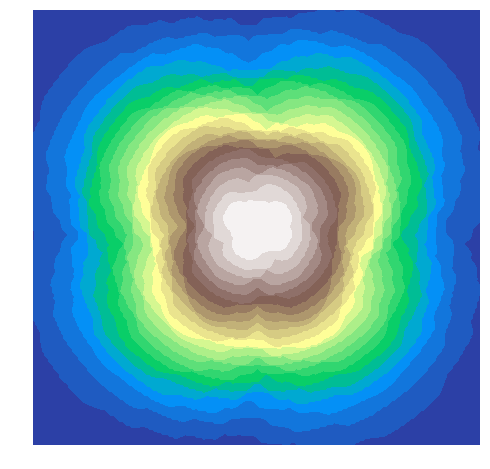

In [27]:
from island import island

plot_height(island)

* The `quantum_island` below is made using the second method from the last section, in which the texture is positioned randomly.

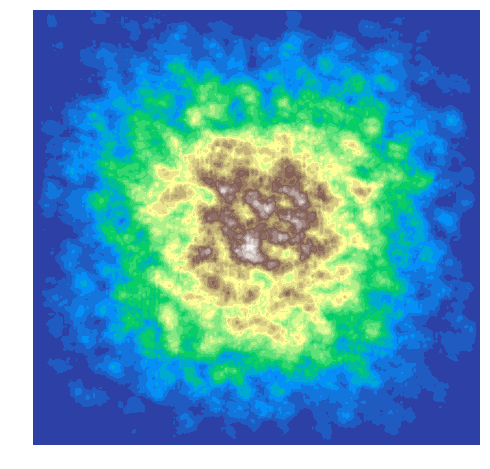

In [29]:
size = max(max(island))+1

quantum_island = {}
for xx in range(size):
    for yy in range(size):
        quantum_island[xx,yy] = 0

for _ in range(int(20*size**2/L**2)):
    chosen = False
    while not chosen:
        x0 = random.randint(0,size-1)
        y0 = random.randint(0,size-1)
        chosen = (random.random()<island[x0,y0])
    blob = random.choice(blobs)
    for (x,y) in blob:
        xx = x-int(L/2)+x0
        yy = y-int(L/2)+y0 
        if (xx,yy) in quantum_island:
            quantum_island[xx,yy] += blob[x,y]
        else:
             quantum_island[xx,yy] = blob[x,y]  
                
max_height = max(quantum_island.values())

for (xx,yy) in quantum_island:
    quantum_island[xx,yy] = quantum_island[xx,yy]/max_height
    
plot_height(quantum_island)

* We'll use this in the combined terrain generation procedure of [Section 5](5_A_Combined_Approach.ipynb).

In [30]:
with open('quantum_island.py', 'w') as file:
    file.write('quantum_island='+str(quantum_island))